## Importar módulos

In [96]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly
import kaleido
import plotly.io as pio

import os
import json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# mapas interactivos
import folium
from folium.plugins import FastMarkerCluster
import geopandas as gpd
from branca.colormap import LinearColormap

#to make the plotly graphs
import plotly.graph_objs as go
import chart_studio.plotly as py
from plotly.offline import iplot, init_notebook_mode
#import cufflinks
#cufflinks.go_offline(connected=True)
#init_notebook_mode(connected=True)

#text mining
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud


## 0. Listado de viviendas: Ginebra
1. Lectura de datos y preprocesamiento

El conjunto de datos contiene un total de 7 archivos. El archivo de listados es un archivo de descripción general que las etiquetas internas de airbnb como "bueno para visualizaciones". El identificador único en el conjunto de datos es la identificación de "listings". Esta es básicamente la identificación del anuncio. En general, había 2271 listados de Airbnb en Ginebra el 30 de Marzo de 2023.


In [97]:
#os.getcwd()

In [98]:
listings = pd.read_csv("listings.csv", index_col= "id")
listings_details = pd.read_csv("listings_details.csv", index_col= "id", low_memory=False)

calendar = pd.read_csv("calendar.csv", parse_dates=['date'], index_col=['listing_id'])
reviews_details = pd.read_csv("reviews_details.csv", parse_dates=['date'])

In [99]:
print(listings.shape)

(2271, 17)


In [100]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2271 entries, 42515 to 2675703
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            2271 non-null   object 
 1   host_id                         2271 non-null   int64  
 2   host_name                       2271 non-null   object 
 3   neighbourhood_group             0 non-null      float64
 4   neighbourhood                   2271 non-null   object 
 5   latitude                        2271 non-null   float64
 6   longitude                       2271 non-null   float64
 7   room_type                       2271 non-null   object 
 8   price                           2271 non-null   int64  
 9   minimum_nights                  2271 non-null   int64  
 10  number_of_reviews               2271 non-null   int64  
 11  last_review                     1820 non-null   object 
 12  reviews_per_month          

El archivo de listados contiene 17 variables por listado además del id.

In [101]:
listings.columns

Index(['name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm', 'license'],
      dtype='object')

In [102]:
listings_details.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2271 entries, 42515 to 857234939912027766
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   listing_url                                   2271 non-null   object 
 1   scrape_id                                     2271 non-null   int64  
 2   last_scraped                                  2271 non-null   object 
 3   source                                        2271 non-null   object 
 4   name                                          2271 non-null   object 
 5   description                                   2202 non-null   object 
 6   neighborhood_overview                         1137 non-null   object 
 7   picture_url                                   2271 non-null   object 
 8   host_id                                       2271 non-null   int64  
 9   host_url                                     

El archivo listados_detalles contiene un total de 74 variables. No vamos a usar todos estos, sino que juntaremos selectivamente una serie de variables que parecen útiles para este EDA.

In [103]:
target_columns = ["property_type", "accommodates", "first_review", "review_scores_value", "review_scores_cleanliness", "review_scores_location", "review_scores_accuracy", "review_scores_communication", "review_scores_checkin", "review_scores_rating", "maximum_nights", "listing_url", "host_is_superhost", "host_about", "host_response_time", "host_response_rate", "neighborhood_overview", "host_identity_verified"]
listings = pd.merge(listings, listings_details[target_columns], on='id', how='left')
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2271 entries, 42515 to 2675703
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            2271 non-null   object 
 1   host_id                         2271 non-null   int64  
 2   host_name                       2271 non-null   object 
 3   neighbourhood_group             0 non-null      float64
 4   neighbourhood                   2271 non-null   object 
 5   latitude                        2271 non-null   float64
 6   longitude                       2271 non-null   float64
 7   room_type                       2271 non-null   object 
 8   price                           2271 non-null   int64  
 9   minimum_nights                  2271 non-null   int64  
 10  number_of_reviews               2271 non-null   int64  
 11  last_review                     1820 non-null   object 
 12  reviews_per_month          

A continuación se muestra el conjunto de datos con el que vamos a trabajar.
Además, en el siguiente enlace se puede acceder a la descripción de cada una de las variables que contiene dicho conjunto de datos:
https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit#gid=1322284596

### Preprocesamiento

2. Limpieza de datos:

    - Se puede observar que el grupo de vecindario y la licencia son dos aspectos inútiles en Ginebra, puesto que al no tener valores en el dataset no aportan información de ningún tipo. Por tanto, las elimino de nuestro conjunto de datos.
    - La velocidad de respuesta del anfitrión aparece en porcentaje, para cambiar el tipo de variable a numérica le quitamos el símbolo del %.
    - Los valores nulos de las valoraciones los sustituyo poro la media de todos los valores.
    - Creo nuevas columnas como legality, crime_rate and security_rate (a partir de los últimos datos publicados sobre criminalidad por el gobierno suizo (estadísticas de 2022): http://www.citypopulation.de/en/switzerland/geneve/, https://www.ge.ch/document/statistique-policiere-criminalite-2022-commune, https://www.swissinfo.ch/fre/societe/ins%C3%A9curit%C3%A9-en-suisse_la-criminalit%C3%A9-d-un-des-pays-les-plus-s%C3%BBrs-du-monde/46255492).
    - Los valores atípicos de la columna precio se sustituyeron por la mediana para poder trabajar con esta variable.
    

In [104]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2271 entries, 42515 to 2675703
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            2271 non-null   object 
 1   host_id                         2271 non-null   int64  
 2   host_name                       2271 non-null   object 
 3   neighbourhood_group             0 non-null      float64
 4   neighbourhood                   2271 non-null   object 
 5   latitude                        2271 non-null   float64
 6   longitude                       2271 non-null   float64
 7   room_type                       2271 non-null   object 
 8   price                           2271 non-null   int64  
 9   minimum_nights                  2271 non-null   int64  
 10  number_of_reviews               2271 non-null   int64  
 11  last_review                     1820 non-null   object 
 12  reviews_per_month          

In [105]:
listings = listings.drop(columns=['neighbourhood_group','license'])
listings['host_response_rate'] = pd.to_numeric(listings['host_response_rate'].str.strip('%'))


In [106]:
Q3 = np.percentile(listings['price'], 75)
Q1 = np.percentile(listings['price'], 25)
upper = Q3 + 1.5*(Q3-Q1)
print('Upper limit: {}'.format(upper))
median=listings['price'].median()
print('Median: {}'.format(median))

Upper limit: 278.5
Median: 115.0


In [107]:
# listings.replace({'host_identity_verified': {'t':1, 'f':0}, 'instant_bookable': {'t':1, 'f':0}}, inplace=True)
# listings.replace({'host_identity_verified': {'t':1, 'f':0}, 'instant_bookable': {'t':1, 'f':0}}, inplace=True)
listings['review_scores_location'].fillna(listings['review_scores_location'].mean(), inplace=True)
listings['review_scores_communication'].fillna(listings['review_scores_communication'].mean(), inplace=True)
listings['review_scores_cleanliness'].fillna(listings['review_scores_cleanliness'].mean(), inplace=True)
listings['review_scores_accuracy'].fillna(listings['review_scores_accuracy'].mean(), inplace=True)
listings['review_scores_checkin'].fillna(listings['review_scores_checkin'].mean(), inplace=True)
listings['price'].mask(listings['price'] >278.5 , listings['price'].median(), inplace=True)
listings['host_is_superhost'] = listings['host_is_superhost'].replace({"f": "Anfitrión estándar", "t": "Superanfitrión"})
listings.head()

#listings['host_identity_verified'].apply(lambda value: 0 if value == 'f' else 1)
#listings['host_is_superhost'].apply(lambda value: 0 if value == 'f' else 1)
#listings['instant_bookable'].apply(lambda value: 0 if value == 'f' else 1)
#listings.head()

name  host_id host_name  \
id                                                                  
42515          Geneva center - Hosting females   185647    Noelle   
107438     Room in an amazingflat linked to UN   556499     F. M.   
203997  Top location studio 1 block from lake!  1001280      Mike   
276025              Lovely flat by Geneva lake  1442438      Gaby   
411058               5th Sky (Downtown Geneva)  1706035     Julik   

            neighbourhood  latitude  longitude        room_type  price  \
id                                                                       
42515   Commune de Genève  46.20140    6.15507     Private room     79   
107438  Commune de Genève  46.19004    6.16014     Private room     60   
203997  Commune de Genève  46.19967    6.15597  Entire home/apt    165   
276025            Versoix  46.27944    6.16724  Entire home/apt     70   
411058  Commune de Genève  46.21092    6.14588     Private room    125   

        minimum_nights  number_of_reviews  ... review_scores_checkin  \
id                                         ...                         
42515                3                 68  ...                  4.83   
107438               5                 27  ...                  4.76   
203997               5                 77  ...                  4.97   
276025               4                115  ...                  4.87   
411058               2                 49  ...                  4.93   

        review_scores_rating  maximum_nights  \
id                                             
42515                   4.71            1125   
107438                  4.87            1125   
203997                  4.89             730   
276025                  4.64             360   
411058                  4.77              15   

                                listing_url   host_is_superhost  \
id                                                                
42515    https://www.airbnb.com/rooms/42515      Superanfitrión   
107438  https://www.airbnb.com/rooms/107438  Anfitrión estándar   
203997  https://www.airbnb.com/rooms/203997      Superanfitrión   
276025  https://www.airbnb.com/rooms/276025      Superanfitrión   
411058  https://www.airbnb.com/rooms/411058  Anfitrión estándar   

                                               host_about  host_response_time  \
id                                                                              
42515   Hi, I am a Management consultant professional,...        within a day   
107438  It is a cosy furnished room with wifi connexio...  a few days or more   
203997  I love airbnb, both for hosting and traveling....      within an hour   
276025  Hi, my name is Gaby! I'm a globetrotter. I spe...      within an hour   
411058  Hello traveler. I'm a humanist consultant work...        within a day   

       host_response_rate                              neighborhood_overview  \
id                                                                             
42515               100.0                                                NaN   
107438               40.0                                                NaN   
203997              100.0  This is the most sought after area in Geneva: ...   
276025              100.0                                                NaN   
411058              100.0  The Pâquis quarter is one of Geneva's most col...   

        host_identity_verified  
id                              
42515                        t  
107438                       t  
203997                       t  
276025                       t  
411058                       t  

[5 rows x 33 columns]

# 1. Introducción
Suiza es un país que esta territorialmente estructurado en 26 cantones, los cuales se dividen en comunas. El cantón de Ginebra está compuesto por 45 comunas. Como este cantón es de los más pequeños de Suiza en comparación con los demás Airbnb considera el cantón completo como una ciudad y sus comunas como vecindarios.


# 2. Análisis exploratorio general
## 2.1 Municipio




Como se puede ver en los gráficos y mapas representados en este apartado, la mayoría de los alojamientos ofertados se concentran en la comuna de Ginebra que corresponde al centro del cantón de Ginebra. Estando la mayoría rodeando la estación de tren princpipal.


In [108]:
import plotly.express as px

feq=listings['neighbourhood'].value_counts().sort_values(ascending=True)

fig = px.bar(listings, x=feq.values, y=feq.index, orientation='h', labels={'y':'Municipio', 'x':'Número de alojamientos'}, title='Número de alojamientos por municipio',width=900, height=800)
fig.show()

In [109]:
lats2023 = listings['latitude'].tolist()
lons2023 = listings['longitude'].tolist()
locations = list(zip(lats2023, lons2023))
# airport = {'latitude': 46.23810, 'longitude':6.10895}
# train_station = {'latitude': 46.21023, 'longitude': 6.14262}
# ONU = {'latitude':46.22659,'longitude':6.1406}
# MBlanc = {'latitude':46.2075,'longitude':6.1484}

map1 = folium.Map(location=[46.204391, 6.143158], zoom_start=12)
FastMarkerCluster(data=locations).add_to(map1)
# folium.Marker([airport['latitude'], airport['longitude']],
#              icon=folium.Icon(color="red", icon="plane"),).add_to(map1)
# folium.Marker([train_station['latitude'], train_station['longitude']],
#              icon=folium.Icon(color="red", icon="info-sign"),).add_to(map1)
# folium.Marker([ONU['latitude'], ONU['longitude']],
#              icon=folium.Icon(color="green", icon="info-sign"),).add_to(map1)
# folium.Marker([MBlanc['latitude'], MBlanc['longitude']],
#              icon=folium.Icon(color="green", icon="info-sign"),).add_to(map1)

map1

## 2.2 Tipos de propiedades y habitaciones según la comuna

En función de la comuna en la que nos centremos podemos ver
que los alojamientos ofertados son de distinto tipo. Por ejemplo: en la Comuna de Ginebra se ofertan más apartamentos enteros y para 2 personas, mientras que en otras como Grand-Saconnex se ofertan más habitaciones privadas para 1 y 2 personas. Esto se debe principalmente a la estructura común de los edificios en cada comuna, puesto que en la Comuna de Ginebra hay muchos más edificios altos y suelen tratarse de oficinas o apartamentos pequeños. En las comunas más alejadas del centro del cantón existen más casas y edificios más bajitos que suelen tener apartamentos más grandes y suelen alquilar por habitaciones en lugar de espacios enteros. 
    



In [110]:
listings['neighbourhood'].unique()

array(['Commune de Genève', 'Versoix', 'Avully', 'Vernier',
       'Plan-les-Ouates', 'Chêne-Bougeries', 'Grand-Saconnex', 'Carouge',
       'Genthod', 'Onex', 'Veyrier', 'Meyrin', 'Chêne-Bourg',
       'Vandoeuvres', 'Pregny-Chambésy', 'Lancy', 'Confignon', 'Cologny',
       'Collonge-Bellerive', 'Bellevue', 'Bardonnex', 'Thônex', 'Satigny',
       'Laconnex', 'Bernex', 'Troinex', 'Hermance', 'Anières', 'Puplinge',
       'Céligny', 'Gy', 'Russin', 'Soral', 'Dardagny', 'Corsier',
       'Meinier', 'Presinge', 'Perly-Certoux', 'Collex-Bossy', 'Jussy',
       'Chancy'], dtype=object)

In [111]:
feq2=listings['room_type'].value_counts().sort_values(ascending=True)

fig = px.bar(listings, x=feq2.values, y=feq2.index, orientation='h', labels={'y':'Tipo de alojamiento', 'x':'Número de alojamientos'}, title='Tipos de alojamiento',width=500, height=400)
fig.show()

In [112]:
listings.property_type.unique()

array(['Private room in rental unit', 'Entire rental unit',
       'Private room in loft', 'Private room in bed and breakfast',
       'Entire condo', 'Private room in home', 'Entire place',
       'Entire loft', 'Entire home', 'Entire bungalow',
       'Shared room in loft', 'Entire serviced apartment',
       'Shared room in rental unit', 'Private room in villa',
       'Room in hotel', 'Entire guest suite', 'Private room in condo',
       'Shared room in home', 'Entire guesthouse', 'Entire villa',
       'Tiny home', 'Shared room', 'Yurt', 'Room in aparthotel',
       'Entire townhouse', 'Boat', 'Private room in townhouse',
       'Private room in farm stay', 'Houseboat', 'Room in boutique hotel',
       'Private room in serviced apartment',
       'Private room in casa particular', 'Casa particular',
       'Entire vacation home', 'Private room in chalet'], dtype=object)

Sin embargo, muchos de esos tipos de propiedades tienen muy pocos alojamientos en Ginebra. En la figura a continuación, listings mostramos tipos de propiedades con al menos 5 listados. Como podemos ver, la gran mayoría de las propiedades en Ginebra son casas o apartamentos enteros.

In [113]:
prop = listings.groupby(['property_type','room_type']).room_type.count()
prop = prop.unstack()
prop

room_type                           Entire home/apt  Hotel room  Private room  \
property_type                                                                   
Boat                                            4.0         NaN           NaN   
Casa particular                                 2.0         NaN           NaN   
Entire bungalow                                 1.0         NaN           NaN   
Entire condo                                  150.0         NaN           NaN   
Entire guest suite                              8.0         NaN           NaN   
Entire guesthouse                               9.0         NaN           NaN   
Entire home                                    49.0         NaN           NaN   
Entire loft                                    25.0         NaN           NaN   
Entire place                                    4.0         NaN           NaN   
Entire rental unit                           1301.0         NaN           NaN   
Entire serviced apartment                      31.0         NaN           NaN   
Entire townhouse                                7.0         NaN           NaN   
Entire vacation home                            6.0         NaN           NaN   
Entire villa                                   11.0         NaN           NaN   
Houseboat                                       1.0         NaN           NaN   
Private room in bed and breakfast               NaN         NaN          59.0   
Private room in casa particular                 NaN         NaN          10.0   
Private room in chalet                          NaN         NaN           1.0   
Private room in condo                           NaN         NaN          42.0   
Private room in farm stay                       NaN         NaN           1.0   
Private room in home                            NaN         NaN          55.0   
Private room in loft                            NaN         NaN           4.0   
Private room in rental unit                     NaN         NaN         391.0   
Private room in serviced apartment              NaN         NaN           3.0   
Private room in townhouse                       NaN         NaN          12.0   
Private room in villa                           NaN         NaN          11.0   
Room in aparthotel                              NaN         2.0           NaN   
Room in boutique hotel                          3.0         2.0           9.0   
Room in hotel                                   NaN         2.0          39.0   
Shared room                                     NaN         NaN           NaN   
Shared room in home                             NaN         NaN           NaN   
Shared room in loft                             NaN         NaN           NaN   
Shared room in rental unit                      NaN         NaN           NaN   
Tiny home                                       2.0         NaN           NaN   
Yurt                                            1.0         NaN           NaN   

room_type                           Shared room  
property_type                                    
Boat                                        NaN  
Casa particular                             NaN  
Entire bungalow                             NaN  
Entire condo                                NaN  
Entire guest suite                          NaN  
Entire guesthouse                           NaN  
Entire home                                 NaN  
Entire loft                                 NaN  
Entire place                                NaN  
Entire rental unit                          NaN  
Entire serviced apartment                   NaN  
Entire townhouse                            NaN  
Entire vacation home                        NaN  
Entire villa                                NaN  
Houseboat                                   NaN  
Private room in bed and breakfast           NaN  
Private room in casa particular             NaN  
Private room in chalet                      NaN  
Pr

In [114]:
prop = listings.groupby(['property_type','room_type']).room_type.count()
prop = prop.unstack()
prop['total'] = prop.iloc[:,0:3].sum(axis = 1)
prop = prop.sort_values(by=['total']) 
prop = prop[prop['total']>=5]
prop = prop.drop(columns=['total'])


In [115]:
prop

room_type                          Entire home/apt  Hotel room  Private room  \
property_type                                                                  
Entire vacation home                           6.0         NaN           NaN   
Entire townhouse                               7.0         NaN           NaN   
Entire guest suite                             8.0         NaN           NaN   
Entire guesthouse                              9.0         NaN           NaN   
Private room in casa particular                NaN         NaN          10.0   
Entire villa                                  11.0         NaN           NaN   
Private room in villa                          NaN         NaN          11.0   
Private room in townhouse                      NaN         NaN          12.0   
Room in boutique hotel                         3.0         2.0           9.0   
Entire loft                                   25.0         NaN           NaN   
Entire serviced apartment                     31.0         NaN           NaN   
Room in hotel                                  NaN         2.0          39.0   
Private room in condo                          NaN         NaN          42.0   
Entire home                                   49.0         NaN           NaN   
Private room in home                           NaN         NaN          55.0   
Private room in bed and breakfast              NaN         NaN          59.0   
Entire condo                                 150.0         NaN           NaN   
Private room in rental unit                    NaN         NaN         391.0   
Entire rental unit                          1301.0         NaN           NaN   

room_type                          Shared room  
property_type                                   
Entire vacation home                       NaN  
Entire townhouse                           NaN  
Entire guest suite                         NaN  
Entire guesthouse                          NaN  
Private room in casa particular            NaN  
Entire villa                               NaN  
Private room in villa                      NaN  
Private room in townhouse                  NaN  
Room in boutique hotel                     NaN  
Entire loft                                NaN  
Entire serviced apartment                  NaN  
Room in hotel                              NaN  
Private room in condo                      NaN  
Entire home                                NaN  
Private room in home                       NaN  
Private room in bed and breakfast          NaN  
Entire condo                               NaN  
Private room in rental unit                NaN  
Entire rental unit                         NaN

In [116]:
fig = go.Figure()
fig.add_trace(go.Bar(x=prop['Entire home/apt'], y=prop.index, name='Entire home/apt', orientation = 'h'))
fig.add_trace(go.Bar(x=prop['Private room'], y=prop.index, name='Private room', orientation = 'h'))
fig.update_layout(barmode= 'stack', title = 'Tipos de propiedades en Ginebra')


In [117]:
feq3=listings['accommodates'].value_counts().sort_index()

fig = px.bar(listings, x=feq3.index, y=feq3.values, labels={'y':'Número de alojamientos', 'x':'Tipo de alojamiento'}, title='Tipos de alojamiento',width=700, height=400)
fig.show()

# 3. Analítica al servicio del gobierno

Si nuestro proyecto estuviese destinado a aconsejar al gobierno sobre lo que ocurre con los alquileres temporales en Ginebra acorde a las leyes establecidas en el cantón, podemos encontrar lo siguiente. 

La principal regla que tiene el cantón de Ginebra es la limitación del alquiler de apartamentos enteros durante más de 90 noches a una misma persona. Si este límite de tiempo se sobrepasa tanto el inquilino como el anfitrión deben de pasar un proceso burocrático diferente y cumplir unos requisitos específicos (porque el cantón lo considera como cambio de residente general del alojamiento) a simplemente el proceso de alquiler por Airbnb.

Por tanto se analizaron los alojamientos que si y los que no seguían esta normativa:



In [118]:
entireplace = listings.loc[listings['room_type'] == 'Entire home/apt']

In [119]:
def legality(maximum_nights):
    if maximum_nights <= 90:
        return 'legal'
    else :
        return 'illegal'

In [120]:
entireplace['legality'] = entireplace['maximum_nights'].apply(legality)

/var/folders/fz/b00vs8k12sdgdl6kydfwl5080000gn/T/ipykernel_69252/3650255231.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [121]:
feq4=entireplace[['legality','maximum_nights']].value_counts().reset_index()

In [122]:
fig = px.scatter(entireplace, x=feq4['maximum_nights'], y=feq4[0], color= feq4['legality'], labels={'y':'Número de alojamientos', 'x':'Número máximo de noches para alojarse'}, title='Número máximo de noches para alojarse en alojamientos enteros',width=1000, height=400)
fig.show()

## 3.1 Identificando empresas infiltradas en Airbnb

Por otro lado, el cantón de Ginebra exige diferentes requisitos, tasas y procesos burocráticos a las empresas que se dedican al alquiler temporal de alojamientos en Ginebra en comparación con los particulares que alquilan sus espacios temporalmente a través de plataformas como la de Airbnb. 
Por tanto, toda empresa dedicada a esto no debería ofertar sus alojamientos a través de Airbnb porque no estaría cumpliendo esta normativa cantonal.

Para tratar de identificar estas empresas infiltradas entre los datos de Airbnb que trabajamos se utilizaron varias estrategias que se detallan a continuación:

- Estudiar el número de habitaciones que alquilaba una misma persona y sobre todo viendo la ubicación de cada una, puesto que si la ubicación de todas o la mayoría es muy parecida podría tratarse de un hotel o alguna tipo de empresa dedicadas a esto. Como punto de corte de número de habitaciones alquiladas por una misma persona se tomó 3 habitaciones, puesto que a simple vista se vió que un hotel estaba ofertando ese número de habitaciones y levantó sospechas.

- Búsqueda de empresas infiltradas por palabras clave, como hotel y compañía tanto en su nombre como en su descripción.

A continuación se muestran algunos ejemplos de las posibles empresas infiltradas identificadas según las estrategias establecidas.


In [123]:
private = listings[listings['room_type'] == "Private room"]
host_private = private.groupby(['host_id', 'host_name']).size().reset_index(name='private_rooms').sort_values(by=['private_rooms'], ascending=False)
host_private[host_private['private_rooms']>=3]





host_id            host_name  private_rooms
86    12766121                 Erik             10
302  166151549            Valentino              9
171   44666245                Marie              9
65     9675348             Philippe              7
304  167921496   Anne-Lise & Daniel              7
19     3528377                 Marc              7
414  422383426       Fassbindhotels              6
369  301468067               Marwan              6
145   31307191               Bianca              5
386  356098872          Hôtel Royal              5
425  441281321              Julieta              5
97    14849570             Brigitte              5
99    15262683                Ivana              4
299  163686220                 Alex              4
423  433785292           Marie-José              4
181   50015263                Cordy              4
387  357435896             M3 Hotel              4
246  101043424              Vanessa              4
350  250017748       Fassbindhotels              4
346  246254421             Darshana              4
139   29267993                 Marc              4
123   22431546         Iris & Dorin              3
384  349487234        Michel , Marc              3
188   54037059                Marie              3
375  327388849     Prospero Antonio              3
392  368535381        Hotel Bristol              3
225   81684011                Samia              3
422  432746132                Muaka              3
377  334034993               Marwan              3
353  260329184        Thérèse Orlie              3
31     4938083                 Rose              3
426  452406873             Isabelle              3
381  341860933  Appart_Hôtel Genève              3
180   49806041             Philippe              3
194   57784954         Vivi, Victor              3
407  414534534               Evince              3

In [124]:
erik = private[private['host_id']== 12766121]
erik = erik[['name','host_id', 'host_name', 'latitude', 'longitude']]
erik.index.name = "listing_id"
erik

name  \
listing_id                                                              
42081324               Great Room at Geneva Airport, Palexpo, UN, WHO   
633804867799448365     Luminous Large Room in Apartment in Eaux-Vives   
634572962022156471  Bright Room nearby Lake Beach Parc and City Ce...   
635414759255537980        Nice Cool Room, Residential Terraces Garden   
643955793301394951      Spacious Room Family House Residential Garden   
810026094545713505  Cosy Room near University City Center and Markets   
810065343532376978  Nice Room near University, City Center and Mar...   
816518830587474195     Bright & Spacious Calm Room UniMail University   
821584544695092726  Spacious Bright Room UniMail University CityCe...   
23495573            Chambre agréable dans villa calme proche aéroport   

                     host_id host_name  latitude  longitude  
listing_id                                                   
42081324            12766121      Erik  46.22879   6.108010  
633804867799448365  12766121      Erik  46.20222   6.157590  
634572962022156471  12766121      Erik  46.20229   6.159100  
635414759255537980  12766121      Erik  46.20963   6.079430  
643955793301394951  12766121      Erik  46.20731   6.194310  
810026094545713505  12766121      Erik  46.19708   6.138799  
810065343532376978  12766121      Erik  46.19708   6.138799  
816518830587474195  12766121      Erik  46.19584   6.138240  
821584544695092726  12766121      Erik  46.19674   6.142730  
23495573            12766121      Erik  46.22278   6.103790

In [125]:

valentino = private[private['host_id']== 166151549]
valentino = valentino[['name','host_id', 'host_name', 'latitude', 'longitude']]
valentino.index.name = "listing_id"
valentino

name    host_id  host_name  latitude  longitude
listing_id                                                                    
44112194            Single Standard  166151549  Valentino  46.21011    6.14089
44112836            Double Business  166151549  Valentino  46.21215    6.14175
45565341            Double Business  166151549  Valentino  46.21177    6.14281
45565446            Double Business  166151549  Valentino  46.21053    6.14099
45565594            Double Business  166151549  Valentino  46.21034    6.14140
45570528            Double Business  166151549  Valentino  46.21174    6.14178
45689697            Double Business  166151549  Valentino  46.21053    6.14159
45689848            Double Business  166151549  Valentino  46.21142    6.14265
558490249735905328  Single Standard  166151549  Valentino  46.21174    6.14166

In [126]:

marie = private[private['host_id']== 44666245]
marie = marie[['name','host_id', 'host_name', 'latitude', 'longitude']]
marie.index.name = "listing_id"
marie

name  \
listing_id                                                              
11830227                      Chambre rétro dans "un jardin en Ville"   
34558834                                  Chambre-bureau +cuisine +++   
699087034939507216  Grande chambre inférieur, accès à cuisine, par...   
15249322            Charmante Suite dans"un jardin en Ville"entrée...   
23478816             Lit-canapé dans supersouplex loft, rez-inférieur   
29259762                   Grande chambre dans souplex-loft-inferieur   
29323288             Chambre romantique avec accès à la cuisine et+++   
29325047            Charmante Suite parentale avec accès à la cuisine   
29383677            Lit-canapé, rez-inferieur accès à la cuisine e...   

                     host_id host_name  latitude  longitude  
listing_id                                                   
11830227            44666245     Marie  46.21018    6.12355  
34558834            44666245     Marie  46.21055    6.12389  
699087034939507216  44666245     Marie  46.21067    6.12464  
15249322            44666245     Marie  46.21018    6.12355  
23478816            44666245     Marie  46.21062    6.12413  
29259762            44666245     Marie  46.20927    6.12440  
29323288            44666245     Marie  46.20955    6.12275  
29325047            44666245     Marie  46.21043    6.12382  
29383677            44666245     Marie  46.21104    6.12391

In [127]:

philippe = private[private['host_id']== 9675348]
philippe = philippe[['name','host_id', 'host_name', 'latitude', 'longitude']]
philippe.index.name = "listing_id"
philippe

name  \
listing_id                                                              
11377087                          chambre a louer N° 2 dans un appart   
42108451                chambre privée, dans mon appartement à thonex   
42119715            Chambre privée N' 2, dans mon appartement à th...   
51069602                 Chambre Privée, à 5 minutes proche de l'ONU,   
53515309                                Chambre Prive a 900 mts - ONU   
720983245946533833     Chambre Prive N° 2 dans un appartement Moderne   
720984313068691950     Genève chambre Prive 1, en appartement Moderne   

                    host_id host_name   latitude  longitude  
listing_id                                                   
11377087            9675348  Philippe  46.205870    6.16404  
42108451            9675348  Philippe  46.195460    6.20118  
42119715            9675348  Philippe  46.193890    6.20081  
51069602            9675348  Philippe  46.236374    6.12452  
53515309            9675348  Philippe  46.212840    6.13435  
720983245946533833  9675348  Philippe  46.200490    6.16611  
720984313068691950  9675348  Philippe  46.200590    6.16628

In [128]:

AnneLiseDaniel = private[private['host_id']== 167921496]
AnneLiseDaniel = AnneLiseDaniel[['name','host_id', 'host_name', 'latitude', 'longitude']]
AnneLiseDaniel.index.name = "listing_id"
AnneLiseDaniel


name    host_id  \
listing_id                                                             
40525699         BIG ROOM CHALET - GENEVA CITY - AEROPORT  167921496   
40528105    MEDIUM ROOM NEW-YORK - GENEVA CITY - AEROPORT  167921496   
40528932        SMALL ROOM DREAM - GENEVA CITY - AEROPORT  167921496   
22742579      2 chambres dans Duplex Aéroport Palexpo ONU  167921496   
22996481         CHALET - PALEXPO ONU BIT OMS CICR GENEVE  167921496   
23304254          DREAM - PALEXPO ONU BIT OMS CICR GENEVE  167921496   
23304953     NEW-YORK  -  PALEXPO ONU BIT OMS CICR GENEVE  167921496   

                     host_name  latitude  longitude  
listing_id                                           
40525699    Anne-Lise & Daniel  46.23478    6.12600  
40528105    Anne-Lise & Daniel  46.23490    6.12558  
40528932    Anne-Lise & Daniel  46.23465    6.12450  
22742579    Anne-Lise & Daniel  46.23528    6.12517  
22996481    Anne-Lise & Daniel  46.23313    6.12515  
23304254    Anne-Lise & Daniel  46.23291    6.12485  
23304953    Anne-Lise & Daniel  46.23375    6.12115

In [129]:
Marc = private[private['host_id']== 3528377]
Marc = Marc[['name','host_id', 'host_name', 'latitude', 'longitude']]
Marc.index.name = "listing_id"
Marc
#https://www.airbnb.es/rooms/21599640?_set_bev_on_new_domain=1685382364_Y2U0N2ZhNTYzYTMx&source_impression_id=p3_1685465163_tDMbAEj5nGz1FNIy
#HOTEL CONFIRMADO#

name  host_id  \
listing_id                                                               
19820423              Large Room near Airport, Palexpo & More  3528377   
20047620           Large Room near Airport, Palexpo & More '2  3528377   
16257749        Spacious & Cosy Quadruple Room - Geneva Heart  3528377   
16821125    Spacious & Cosy Quadruple Studio - Geneva Hear...  3528377   
21090658    Nice Privateroom close to Jet D'eau, Lake,Old ...  3528377   
21599640          Spacious & Cosy King Room - Geneva Heart '2  3528377   
29474298          Spacious & Cosy King Room - Geneva Heart '3  3528377   

           host_name  latitude  longitude  
listing_id                                 
19820423        Marc  46.21901    6.10910  
20047620        Marc  46.22027    6.10987  
16257749        Marc  46.20044    6.16160  
16821125        Marc  46.20152    6.16072  
21090658        Marc  46.20020    6.16352  
21599640        Marc  46.20044    6.16160  
29474298        Marc  46.19925    6.16219

In [130]:

marwan = private[private['host_id']== 301468067]
marwan = marwan[['name','host_id', 'host_name', 'latitude', 'longitude']]
marwan.index.name = "listing_id"
marwan

name    host_id host_name  \
listing_id                                                                    
39268035                 Single room Without breakfast  301468067    Marwan   
39287864    Chambre Double avec Salle de Bains Commune  301468067    Marwan   
39621518        Chambre individuelle avec douche et WC  301468067    Marwan   
39621539              Chambre double avec douche et WC  301468067    Marwan   
45777110        Chambre individuelle avec douche et WC  301468067    Marwan   
45777389       Chambre Double avec Douche et WC  Privé  301468067    Marwan   

            latitude  longitude  
listing_id                       
39268035    46.20669    6.13893  
39287864    46.20601    6.14046  
39621518    46.20509    6.13971  
39621539    46.20674    6.14115  
45777110    46.20478    6.13958  
45777389    46.20468    6.13937

In [131]:

bianca = private[private['host_id']== 31307191]
bianca = bianca[['name','host_id', 'host_name', 'latitude', 'longitude']]
bianca.index.name = "listing_id"
bianca


name   host_id  \
listing_id                                                                   
18018494                     73 Room Centre ONU NU CERN aéroport  31307191   
41496102                              70 Chambre B Cornavin Gare  31307191   
41837357                                  73 Room B Centre-ville  31307191   
566591957635069065               72 chambre Genève gare Cornavin  31307191   
22722210            73 Room Chambre Cornavin ONU Centre Aeroport  31307191   

                   host_name   latitude  longitude  
listing_id                                          
18018494              Bianca  46.212189   6.132794  
41496102              Bianca  46.211666   6.133802  
41837357              Bianca  46.212601   6.133722  
566591957635069065    Bianca  46.211704   6.132181  
22722210              Bianca  46.212440   6.133525

In [132]:
julieta = private[private['host_id']== 441281321]
julieta = julieta[['name','host_id', 'host_name', 'latitude', 'longitude']]
julieta.index.name = "listing_id"
julieta

name    host_id host_name  latitude  \
listing_id                                                              
54373350             Chambre charmante  441281321   Julieta  46.20542   
554061316200889563  Chambre Romantique  441281321   Julieta  46.20637   
554063971965723176    Chambre atypique  441281321   Julieta  46.20672   
554088538015644753  Chambre douillette  441281321   Julieta  46.20530   
815450395748355268    Chambre exotique  441281321   Julieta  46.20558   

                    longitude  
listing_id                     
54373350              6.07498  
554061316200889563    6.07443  
554063971965723176    6.07327  
554088538015644753    6.07496  
815450395748355268    6.07465

In [133]:
brigitte = private[private['host_id']== 14849570]
brigitte = brigitte[['name','host_id', 'host_name', 'latitude', 'longitude']]
brigitte.index.name = "listing_id"
brigitte #parece que era potencialmente ilegal porque estos anuncios han desaparecido de la pag web de airbnb

name   host_id host_name  latitude  \
listing_id                                                                  
35257942        3rd charming room in Geneva  14849570  Brigitte  46.20039   
35854286        4th charming room in Geneva  14849570  Brigitte  46.20039   
35862520        5th charming room in Geneva  14849570  Brigitte  46.20039   
22264281        1st charming room in Geneva  14849570  Brigitte  46.20039   
25046205    2ème chambre charmante à Genève  14849570  Brigitte  46.20039   

            longitude  
listing_id             
35257942      6.17554  
35854286      6.17554  
35862520      6.17554  
22264281      6.17554  
25046205      6.17554

In [134]:

ivana = private[private['host_id']== 15262683]
ivana = ivana[['name','host_id', 'host_name', 'latitude', 'longitude']]
ivana.index.name = "listing_id"
ivana 

name   host_id host_name  \
listing_id                                                                  
7398079        Chambre près Aéroport/Palexpo/ONU/Gare  15262683     Ivana   
8263520           Room close to Airport, Palexpo, ONU  15262683     Ivana   
11233576           Chambre cosy Palexpo /Aéroport/Onu  15262683     Ivana   
38506719    Private room near airport - palexpo - ONU  15262683     Ivana   

            latitude  longitude  
listing_id                       
7398079     46.22968    6.11939  
8263520     46.23024    6.11855  
11233576    46.23044    6.11776  
38506719    46.22867    6.11972

In [135]:

alex = private[private['host_id']== 163686220]
alex = alex[['name','host_id', 'host_name', 'latitude', 'longitude']]
alex.index.name = "listing_id"
alex

name  \
listing_id                                                              
51864201              ⭐⭐⭐United Nations Private bright room & Balcony   
52062767            ⭐⭐⭐⭐⭐United Nations Private BIG room with Balcony   
52543311            ⭐⭐⭐⭐United Nations Private bright room  & Balcony   
626043600949952895      🌟🌟🌟🌟United Nations Private big room & Balcony   

                      host_id host_name  latitude  longitude  
listing_id                                                    
51864201            163686220      Alex  46.21546    6.13499  
52062767            163686220      Alex  46.21295    6.13688  
52543311            163686220      Alex  46.21505    6.13412  
626043600949952895  163686220      Alex  46.21541    6.13547

In [136]:

mj = private[private['host_id']== 433785292]
mj = mj[['name','host_id', 'host_name', 'latitude', 'longitude']]
mj.index.name = "listing_id"
mj

name    host_id  \
listing_id                                                                 
53565754            Peaceful room, 7 min walk to the airport!  433785292   
53590428               Room cosy 7 min walk from the airport!  433785292   
53591007      Romantic room 7 minutes walk from the airport !  433785292   
53599203    Chambre économique à 7 min à pied de l'aéroport !  433785292   

             host_name  latitude  longitude  
listing_id                                   
53565754    Marie-José  46.22662   6.109054  
53590428    Marie-José  46.22662   6.109054  
53591007    Marie-José  46.22662   6.109054  
53599203    Marie-José  46.23162   6.112770

In [137]:

cordy = private[private['host_id']== 50015263]
cordy = cordy[['name','host_id', 'host_name', 'latitude', 'longitude']]
cordy.index.name = "listing_id"
cordy

name   host_id  \
listing_id                                                             
749872581626157468      Genève centre chambre lit double G  50015263   
751645606760603691      Genève chambre avec balcon privé V  50015263   
751649413498082115          Chambre d’hôte Genève centre R  50015263   
751651916849339409  Chambre très spacieuse Genève centre B  50015263   

                   host_name  latitude  longitude  
listing_id                                         
749872581626157468     Cordy  46.20310    6.13904  
751645606760603691     Cordy  46.20290    6.13939  
751649413498082115     Cordy  46.20286    6.13759  
751651916849339409     Cordy  46.20385    6.13874

In [138]:

vanessa = private[private['host_id']== 101043424]
vanessa = vanessa[['name','host_id', 'host_name', 'latitude', 'longitude']]
vanessa.index.name = "listing_id"
vanessa

name  \
listing_id                                                             
39546728            ONU, OMC, OMS, CICR, UIT Quartier international.   
557921110626594993                Genève, bord du lac, ONU, OMS ,OMC   
558298713574718804              Genève idéal pour groupe ou famille.   
560652307825384719      ONU, OMC, OMS, Bord du lac, jardin botanique   

                      host_id host_name  latitude  longitude  
listing_id                                                    
39546728            101043424   Vanessa  46.22310    6.14849  
557921110626594993  101043424   Vanessa  46.22205    6.14816  
558298713574718804  101043424   Vanessa  46.22286    6.14783  
560652307825384719  101043424   Vanessa  46.22196    6.14887

In [139]:

Darshana= private[private['host_id']== 246254421]
Darshana = Darshana[['name','host_id', 'host_name', 'latitude', 'longitude']]
Darshana.index.name = "listing_id"
Darshana

name  \
listing_id                                                              
52584217                 Beautiful place to stay in the city 🌆 center   
52615378                Bright and spacious room in the city 🏙 center   
52615413            Lovely 😊 attractive , quite place🏡 in the center.   
608701252289835809            Lovely bedroom close to the genève lake   

                      host_id host_name   latitude  longitude  
listing_id                                                     
52584217            246254421  Darshana  46.210650   6.148980  
52615378            246254421  Darshana  46.211860   6.147590  
52615413            246254421  Darshana  46.212400   6.147520  
608701252289835809  246254421  Darshana  46.213177   6.149165

In [140]:

marc2= private[private['host_id']== 29267993]
marc2 = marc2[['name','host_id', 'host_name', 'latitude', 'longitude']]
marc2.index.name = "listing_id"
marc2

name   host_id  \
listing_id                                                                
42767597          Mandarin Room UNO, WHO, ILO, UNHCR, PALEXPO  29267993   
42768517              Lime Room UNO, WHO, ILO, UNHCR ,PALEXPO  29267993   
42805752    CherrySuite WHO, ILO, PALEXPO, GLOBALFUND,UNAIDS…  29267993   
42850402            Royal Suite UNO, WHO, ILO, UNHCR ,PALEXPO  29267993   

           host_name  latitude  longitude  
listing_id                                 
42767597        Marc  46.23565    6.12487  
42768517        Marc  46.23441    6.12479  
42805752        Marc  46.23615    6.12451  
42850402        Marc  46.23615    6.12549

In [141]:
host_private[host_private['host_name'].str.contains('hotel|hôtel', case=False)]

host_id            host_name  private_rooms
414  422383426       Fassbindhotels              6
386  356098872          Hôtel Royal              5
387  357435896             M3 Hotel              4
350  250017748       Fassbindhotels              4
392  368535381        Hotel Bristol              3
381  341860933  Appart_Hôtel Genève              3

In [142]:
freq = listings.groupby(['host_id']).size().reset_index(name='num_host_listings')
host_prop = freq.groupby(['num_host_listings']).size().reset_index(name='count').transpose()
host_prop.columns = host_prop.iloc[0]
host_prop = host_prop.drop(host_prop.index[0])
host_prop

num_host_listings    1    2   3   4   5   6   7   8   9   11  12  14  16  17  \
count              1273  155  30  23  14   6   3   3   1   1   1   1   2   2   

num_host_listings  18  28  30  52  87  
count               1   2   1   1   1

A continuación, se muestran los anfitriones con más de 10 listados. Desafortunadamente, host_about no se raspa completamente.

Como probablemente sea difícil implementar y controlar una medida que prohíba por completo las actividades de alojamiento profesional, recomendaría al cantón de Ginebra que considerara establecer un número máximo de listados por host. Si se estableciera esto en, por ejemplo, 3 (y logra que esto se implemente en los sistemas de Airbnb), sería mucho más difícil explotar el hospedaje en Airbnb como una actividad profesional.

Además, se podría implementar requisitios adicionales para verificar la identidad del anfitrión. Si uno de los requisitos fuese ser particular y no formar parte de una empresa que se dedique al alquiler temporal de alojamientos, podrían ir reduciendo esa actividad profesional a través de este tipo de plataformas.

In [143]:
freq = listings.groupby(['host_id', 'host_name', 'host_about','host_is_superhost']).size().reset_index(name='num_host_listings')
freq = freq.sort_values(by=['num_host_listings'], ascending=False)
freq = freq[freq['num_host_listings'] >= 10]
freq

host_id              host_name  \
78     3528377                   Marc   
568  273734321      Homenhancement SA   
406   46143912               Philippe   
85     3737690               Philippe   
230   10409307                  David   
352   31307191                 Bianca   
66     3111534             The Hamlet   
403   44666245                  Marie   
251   12766121                   Erik   
547  229697118  Benjamin Et Philibert   
605  401192039      My Swiss Booking,   

                                            host_about   host_is_superhost  \
78   Keys'n'Fly - Airbnb Management Solution That S...  Anfitrión estándar   
568  Nous gérons plus de 400 appartements à Genève ...  Anfitrión estándar   
406                weDoux - Airbnb Management Solution  Anfitrión estándar   
85   J'apprécie de faire connaissance avec des gens...      Superanfitrión   
230  Our apartments are welcoming enough to make yo...  Anfitrión estándar   
352  Bonjour et bienvenue sur ma page Airbnb !\n\nD...  Anfitrión estándar   
66   Hi, my name is Anaëlle \nI very much look forw...  Anfitrión estándar   
403  Fraîchement retraitée, j'ai du temps pour rece...  Anfitrión estándar   
251  Nous serons très heureux de vous accueillir à ...      Superanfitrión   
547  My Swiss Concierge - the AirBnB Management Sol...      Superanfitrión   
605  My Swiss Booking - the AirBnB Management Solut...  Anfitrión estándar   

     num_host_listings  
78                  87  
568                 52  
406                 30  
85                  28  
230                 28  
352                 17  
66                  17  
403                 16  
251                 14  
547                 12  
605                 11

In [144]:
freq['host_id'].values

array([  3528377, 273734321,  46143912,   3737690,  10409307,  31307191,
         3111534,  44666245,  12766121, 229697118, 401192039])

In [145]:
for id in freq['host_id'].values:
    print('- {} ({}) description: {}'.format(freq.loc[freq['host_id']==id, ['host_name']].values[0][0], freq.loc[freq['host_id']==id, ['host_id']].values[0][0], freq.loc[freq['host_id']==id, ['host_about']].values[0][0]), end="\n\n")

- Marc (3528377) description: Keys'n'Fly - Airbnb Management Solution That Suits You
My name is Marc with Keys'n'Fly Vacation Rentals, a full service property management company based out of Geneva, Switzerland. My team and I strive to make every experience a seamless one, no matter where your trip may take you. As hospitality professionals experts, we are dedicated to provide superior customer service with attentiveness to inquiries and our guests while they are staying with us. 
Our beloved hosts trust us in managing their properties on their behalf and we hope you will trust us with your stay.
Please let us know how we may help you with your next trip.

- Homenhancement SA (273734321) description: Nous gérons plus de 400 appartements à Genève et 60 appartements à Lausanne. 
Nous avons également des appartements à Bruxelles.
N'hésitez pas à nous contacter pour toute demande d'information complémentaire.
Nous sommes à votre service pour vous aider à trouver le parfait appartement pour

En estas descripciones podemos ver que muchos de estos anfitriones son profesionales dedicados al sector y que por tanto, no están cumpliendo la normativa.

En el mapa que aparece a continuación se muestran los alojamientos ubicados en el cantón de Ginebra que podrían considerarse legales (verde) e ilegales (rojo) de acuerdo a las normativas mencionadas anteriormente.

Se puede observar que existen muchos alojamientos sospechosos de incumplir la normativa vigente, por lo que aconsejaría al cantón de Ginebra que revisase estos datos y tomasen medidas al respecto.

In [146]:
#Legales e ilegales de acuerdo a todas las condiciones consideradas
listings['legality'] = listings['maximum_nights'].apply(legality)
listings['legality'].mask((listings['host_name'].str.contains('hotel|hôtel', case=False)) | (listings['host_about'].str.contains('company|management', case=False)), 'illegal', inplace=True)




In [147]:
legality_color = listings[['neighbourhood','latitude','longitude','legality']]

In [148]:
m = folium.Map(location=[46.204391, 6.143158],width="%100",height="%100")
color_map = {'legal': 'green', 'illegal': 'red'}
for index, row in listings.iterrows():
    folium.CircleMarker(location=[row['latitude'], row['longitude']],radius=1, color=color_map[row['legality']]).add_to(m)
m


# 4. Consejos al turismo

## 4.1 Seguridad en Ginebra

Tras obtener información actualizada (año 2022) del Gobierno de Suiza sobre la criminalidad en el cantón de Ginebra. El índice calculado de criminalidad por cada 100000 habitantes mostró que el centro de Ginebra es el más peligroso aunque según el gobierno el tipo de acto delictivo más común en este cantón son los robos, cosa que puede tener sentido ya que según el mapa ocurre con más frecuencia en las áreas más concurridas del cantón. Aún así, se podría destacar que Suiza no es uno de los países más peligrosos acorde a las estadísticas de Europa. Por lo que este índice de criminalidad solo es comparable entre las comunas que componen el cantón de Ginebra.

El cálculo del índice de criminalidad de cada comuna por cada 100000 habitantes se llevó a cabo de la siguiente forma: 

   ( volúmen de crímenes / volumen de población ) * 100000

Además se creó una escala de seguridad (1-6) para tener una idea de cómo se relacionaba la seguridad por comuna en función al precio y el resto de valoraciones realizadas por visitantes anteriores.

In [149]:
adam = gpd.read_file("./neighbourhoods.geojson")
dic_crime = {'Commune de Genève':2907, 'Versoix':55, 'Avully':9, 'Vernier':200, 'Plan-les-Ouates':104, 'Chêne-Bougeries':140, 'Grand-Saconnex':44, 'Carouge':324,
       'Genthod':16, 'Onex':100, 'Veyrier':90, 'Meyrin':206, 'Chêne-Bourg':133,
       'Vandoeuvres':7, 'Pregny-Chambésy':15, 'Lancy':290, 'Confignon':17, 'Cologny':95,
       'Collonge-Bellerive':36, 'Bellevue':24, 'Bardonnex':14, 'Thônex':169, 'Satigny':28,
       'Laconnex':2, 'Bernex':73, 'Troinex':14, 'Hermance':6, 'Anières':8, 'Puplinge':22,
       'Céligny':4, 'Gy':3, 'Russin':1, 'Soral':10, 'Dardagny':5, 'Corsier':1,
       'Meinier':10, 'Presinge':2, 'Perly-Certoux':26, 'Collex-Bossy':6, 'Jussy':6,
       'Chancy':11}

listings['crime_vol'] =  listings['neighbourhood'].map(dic_crime)
#population 2022 per commune in Geneve, ref: http://www.citypopulation.de/en/switzerland/geneve/
dic_pop = {'Commune de Genève':203757, 'Versoix':13332, 'Avully':1709, 'Vernier':36563, 'Plan-les-Ouates':12088, 'Chêne-Bougeries':13256, 'Grand-Saconnex':12603, 'Carouge':22160,
       'Genthod':2882, 'Onex':18765, 'Veyrier':11897, 'Meyrin':26507, 'Chêne-Bourg':8833,
       'Vandoeuvres':2852, 'Pregny-Chambésy':3991, 'Lancy':34645, 'Confignon':4594, 'Cologny':5971,
       'Collonge-Bellerive':8493, 'Bellevue':4071, 'Bardonnex':2530, 'Thônex':16113, 'Satigny':4449,
       'Laconnex':703, 'Bernex':10250, 'Troinex':2600, 'Hermance':1189, 'Anières':2417, 'Puplinge':2526,
       'Céligny':845, 'Gy':449, 'Russin':536, 'Soral':963, 'Dardagny':1800, 'Corsier':2265,
       'Meinier':2068, 'Presinge':737, 'Perly-Certoux':3139, 'Collex-Bossy':1727, 'Jussy':1193,
       'Chancy':1671}

listings['pop_vol'] =  listings['neighbourhood'].map(dic_pop)

listings['crime_rate'] =  listings['crime_vol']/listings['pop_vol']*100000 # de acuerdo con la definición de crime rate que se establece en Eurostat, esta se calcula con esa fórmula (por cada 100000 habitantes). Ref: https://www.swissinfo.ch/fre/societe/ins%C3%A9curit%C3%A9-en-suisse_la-criminalit%C3%A9-d-un-des-pays-les-plus-s%C3%BBrs-du-monde/46255492

feq = pd.DataFrame([listings.groupby('neighbourhood')['crime_rate'].mean().sort_values(ascending=True)])

#adam = gpd.read_file("neighbourhoods.geojson")
#feq = pd.DataFrame([feq])
feq = feq.transpose()
adam = pd.merge(adam, feq, on='neighbourhood', how='inner')
adam.rename(columns={'crime_rate': 'average_crime_rate'}, inplace=True)
adam.average_crime_rate = adam.average_crime_rate.round(decimals=0)

print('Índice mínimo criminal: {}'.format(adam.average_crime_rate.min()))
print('Índice máximo criminal: {}'.format(adam.average_crime_rate.max()))

# Conseguimos colores para nuestras casas 
map_dict = adam.set_index('neighbourhood')['average_crime_rate'].to_dict()
color_scale = LinearColormap(['green','pink','purple'], vmin = min(map_dict.values()), vmax = max(map_dict.values()))

def get_color(feature):
    value = map_dict.get(feature['properties']['neighbourhood'])
    return color_scale(value)


# Hacemos el mapa
map3 = folium.Map(location=[46.204391, 6.143158], zoom_start=11)
folium.GeoJson(data=adam,
               name='Amsterdam',
               tooltip=folium.features.GeoJsonTooltip(fields=['neighbourhood', 'average_crime_rate'],
                                                      labels=True,
                                                      sticky=True),
               style_function= lambda feature: {
                   'fillColor': get_color(feature),
                   'color': 'black',
                   'weight': 1,
                   'dashArray': '5, 5',
                   'fillOpacity':0.9
                   },
               highlight_function=lambda feature: {'weight':3, 'fillColor': get_color(feature), 'fillOpacity': 0.8}
               ).add_to(map3)
map3.add_child(color_scale)
map3

Índice mínimo criminal: 44.0
Índice máximo criminal: 1591.0


In [150]:
#escalar el crime_rate paara que me quede en un rango de 0-5, con 5 saltos. [0,1,2,3,4,5]

listings['crime_rate'] = listings['crime_rate'].round(decimals=0)
security = np.linspace(listings['crime_rate'].min(),listings['crime_rate'].max(),7,endpoint=True)

def recode_crime_rate(rate):
    if  security[0] <= rate < security[1]:
        return 6
    elif security[1] <= rate < security[2]:
        return 5
    elif security[2] <= rate < security[3]:
        return 4
    elif security[3] <= rate < security[4]:
        return 3
    elif security[4] <= rate <= security[5]:
        return 2
    else:
        return 1

In [151]:
listings['security_rate'] = listings['crime_rate'].apply(recode_crime_rate)

In [152]:
feq = listings[listings['number_of_reviews']>=10]

feq3=feq.groupby('neighbourhood')['review_scores_value'].mean()
feq5=feq.groupby('neighbourhood')['review_scores_location'].mean()
feq4=feq.groupby('neighbourhood')['security_rate'].mean()

fig1 = make_subplots(
    rows=1, cols=2, shared_yaxes=True, subplot_titles=('',''))

fig1.add_trace(go.Bar(x=feq3.values, y=feq3.index,orientation = 'h', name='General'), row=1, col=1)
fig1.add_trace(go.Bar(x=feq5.values, y=feq5.index,orientation = 'h', name='Localización'), row=1, col=1)
fig1.update_xaxes(title_text="Valoración media por vecindario", row=1, col=1)

fig1.add_trace(go.Bar(x=feq4.values, y=feq4.index,orientation = 'h'), row=1, col=2)
fig1.update_xaxes(title_text="Seguridad por vecindario", row=1, col=2)

fig1.update_layout(width=1000, height=700,
                title_text='', showlegend=False, )


fig1.show()

In [153]:
data = listings[['review_scores_rating','review_scores_location','review_scores_communication','review_scores_accuracy','review_scores_checkin','review_scores_cleanliness','security_rate','price']]
corr = data.corr(method = 'spearman')

#mask = np.triu(np.ones_like(corr, dtype=np.bool))
# import plotly.express as px

fig=px.imshow(corr.iloc[0:8,0:8], labels =dict(x="", y="", color="Coeficiente de correlación"), x=corr.iloc[0:8,0:8].index,
                 y=corr.iloc[0:8,0:8].index, text_auto = '.2f', range_color = [-1, 1], color_continuous_scale="viridis",template="plotly_dark", height=600, title="Correlaciones entre valoraciones y precio")

fig

In [154]:
from scipy.stats import spearmanr
data1 = listings['price'].values
data2 = listings['security_rate'].values
stat, p = spearmanr(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('El precio y la seguridad probablemente sean independientes')
else:
    print('El precio y la seguridad probablemente sean dependientes')

from scipy.stats import spearmanr
data1 = listings['security_rate'].values
data2 = listings['review_scores_location'].values
stat, p = spearmanr(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('La seguridad y la localización probablemente sean independientes')
else:
    print('La seguridad y la localización probablemente sean dependientes')




stat=-0.146, p=0.000
El precio y la seguridad probablemente sean dependientes
stat=-0.131, p=0.000
La seguridad y la localización probablemente sean dependientes


Estas correlaciones entre el precio y la localización y el precio inversas aunque débiles se pueden deber a que el índice general de criminalidad en Suiza es bastante bajo (https://es.numbeo.com/criminalidad/pa%25C3%25ADs/Suiza) y por tanto en las zonas más concurridas como el centro de Ginebra son en los que tienen lugar más actos delictivos (especialmente robos, https://es.numbeo.com/criminalidad/ciudad/Ginebra) donde, a su vez, los precios son más altos.

## 4.2 Tipos de viaje según el número de personas que se aloojan

###   4.2.1 Viaje de negocios

Consideremos que a un viaje de negocios solo va una persona, de forma que vamos a ver a continuación los alojamientos ofertados y algunas de sus características en función de la comuna de Ginebra que elijamos pero sólo considerando los alojamientos para una sola persona.

In [155]:
listdf= listings.loc[listings['accommodates'] == 1]

In [156]:
lats2023_1 = listdf['latitude'].tolist()
lons2023_1 = listdf['longitude'].tolist()
locations_1 = list(zip(lats2023_1, lons2023_1))
airport = {'latitude': 46.23810, 'longitude':6.10895}
train_station = {'latitude': 46.21023, 'longitude': 6.14262}
ONU = {'latitude':46.22659,'longitude':6.1406}
MBlanc = {'latitude':46.2075,'longitude':6.1484} 
JD = {'latitude':46.20753,'longitude':6.15595} 
map4 = folium.Map(location=[46.204391, 6.143158], zoom_start=10)
FastMarkerCluster(data=locations_1).add_to(map4)
folium.Marker([airport['latitude'], airport['longitude']],
    icon=folium.Icon(color="red", icon="plane"),).add_to(map4)
folium.Marker([train_station['latitude'], train_station['longitude']],
    icon=folium.Icon(color="red", icon="info-sign"),).add_to(map4)
folium.Marker([ONU['latitude'], ONU['longitude']],
    icon=folium.Icon(color="green", icon="info-sign"),).add_to(map4)
folium.Marker([MBlanc['latitude'], MBlanc['longitude']],
    icon=folium.Icon(color="green", icon="info-sign"),).add_to(map4)
folium.Marker([JD['latitude'], JD['longitude']],
    icon=folium.Icon(color="green", icon="info-sign"),).add_to(map4)
map4

In [157]:
adam = gpd.read_file("./neighbourhoods.geojson")
feq = pd.DataFrame([listdf.groupby('neighbourhood')['price'].mean().sort_values(ascending=True)])

#adam = gpd.read_file("neighbourhoods.geojson")
#feq = pd.DataFrame([feq])
feq = feq.transpose()
adam = pd.merge(adam, feq, on='neighbourhood', how='inner')
adam.rename(columns={'price': 'average_price'}, inplace=True)
adam.average_price = adam.average_price.round(decimals=0)

# Conseguimos colores para nuestras casas 
map_dict = adam.set_index('neighbourhood')['average_price'].to_dict()
color_scale = LinearColormap(['yellow','red'], vmin = min(map_dict.values()), vmax = max(map_dict.values()))

def get_color(feature):
    value = map_dict.get(feature['properties']['neighbourhood'])
    return color_scale(value)

print('El precio medio mínimo de los alojamientos disponibles en Ginebra para una persona es de {}$ y se encuentra en el vecindario {}'.format(adam['average_price'].min(),adam[adam['average_price'] == adam['average_price'].min()]['neighbourhood'].values[0]))
print('El precio medio máximo de los alojamientos disponibles en Ginebra para una persona es de {}$ y se encuentra en el vecindario {}'.format(adam['average_price'].max(),adam[adam['average_price'] == adam['average_price'].max()]['neighbourhood'].values[0]))

# Hacemos el mapa
map3 = folium.Map(location=[46.204391, 6.143158], zoom_start=11)
folium.GeoJson(data=adam,
               name='Amsterdam',
               tooltip=folium.features.GeoJsonTooltip(fields=['neighbourhood', 'average_price'],
                                                      labels=True,
                                                      sticky=True),
               style_function= lambda feature: {
                   'fillColor': get_color(feature),
                   'color': 'black',
                   'weight': 1,
                   'dashArray': '5, 5',
                   'fillOpacity':0.9
                   },
               highlight_function=lambda feature: {'weight':3, 'fillColor': get_color(feature), 'fillOpacity': 0.8}
               ).add_to(map3)
map3



El precio medio mínimo de los alojamientos disponibles en Ginebra para una persona es de 32.0$ y se encuentra en el vecindario Troinex
El precio medio máximo de los alojamientos disponibles en Ginebra para una persona es de 180.0$ y se encuentra en el vecindario Pregny-Chambésy


En estos mapas se puede ver que se ofertan más número de alojamientos en el centro del cantón y además los municipios con precios más altos se encuentran bastante extendidos, de hecho dentro del rango que existe de precios (30-180$) la mayoría se encuentra en la parte superior del rango. El municipio más caro es Pregny-Chambésy para alojamientos de una persona, lo que puede deberse a que en esa zona está el edificio de las Naciones Unidas y puede que haya una alta demanda de alojamientos para una persona por las reuniones y eventos que se celebran allí. 

A continuación se puede observar que hay muchos alojamientos sin valoraciones, de los cuales los visitantes que busquen alojamiento seguramente no se fien, además de que estas valoraciones no aportan información. Por tanto, filtramos los datos para que nos muestre solo aquellos alojamientos que son para una persona y que tienen más de 10 valoraciones al menos.

In [158]:
feq = listings
feq3=feq['number_of_reviews'].value_counts().sort_index()

fig = px.bar(listings, x=feq3.index, y=feq3.values, labels={'y':'Número de alojamientos', 'x':'Número de valoraciones'}, title='',width=700, height=400)
fig.show()

In [159]:
feq = listings
feq3=feq['number_of_reviews'].value_counts().sort_index()

fig = px.bar(listings, x=feq3.index, y=feq3.values, labels={'y':'Número de alojamientos', 'x':'Número de valoraciones'}, title='',width=700, height=400)
fig.show()

In [160]:
listings_negocios = listings.loc[(listings['accommodates']==1) & (listings['number_of_reviews']>=10)]
listings_loc = listings_negocios[['neighbourhood','review_scores_location']].value_counts().reset_index().sort_values('neighbourhood')
listings_clean = listings_negocios[['neighbourhood','review_scores_cleanliness']].value_counts().reset_index().sort_values('neighbourhood')
listings_acc = listings_negocios[['neighbourhood','review_scores_accuracy']].value_counts().reset_index().sort_values('neighbourhood')
listings_com = listings_negocios[['neighbourhood','review_scores_communication']].value_counts().reset_index().sort_values('neighbourhood')
listings_check = listings_negocios[['neighbourhood','review_scores_checkin']].value_counts().reset_index().sort_values('neighbourhood')
listings_rate = listings_negocios[['neighbourhood','review_scores_rating']].value_counts().reset_index().sort_values('neighbourhood')

fig1 = make_subplots(
    rows=3, cols=2,
    subplot_titles=('Location','Cleanliness','Accuracy','Communication','Checkin','Rating'),
    vertical_spacing=0.03, horizontal_spacing=0.1,
    specs=[[{"type": "polar"}]*2]*3)

fig1.add_trace(go.Scatterpolar(theta=listings_loc['neighbourhood'], r=listings_loc['review_scores_location'], mode='markers', marker=dict(color=listings_loc[0], size = 15, cmin = 1,
        cmax = 20, colorbar = dict(title='Number of listings'), colorscale='Viridis_r', colorbar_orientation='h')), row=1, col=1)

fig1.add_trace(go.Scatterpolar(theta=listings_clean['neighbourhood'], r=listings_clean['review_scores_cleanliness'], mode='markers', marker=dict(color=listings_clean[0], size = 15, cmin = 1,
        cmax = 20, colorbar = dict(title='Number of listings'), colorscale='Viridis_r', colorbar_orientation='h')), row=1, col=2)

fig1.add_trace(go.Scatterpolar(theta=listings_acc['neighbourhood'], r=listings_acc['review_scores_accuracy'], mode='markers', marker=dict(color=listings_acc[0], size = 15, cmin = 1,
        cmax = 20, colorbar = dict(title='Number of listings'), colorscale='Viridis_r', colorbar_orientation='h')), row=2, col=1)

fig1.add_trace(go.Scatterpolar(theta=listings_com['neighbourhood'], r=listings_com['review_scores_communication'], mode='markers', marker=dict(color=listings_com[0], size = 15, cmin = 1,
        cmax = 20, colorbar = dict(title='Number of listings'), colorscale='Viridis_r', colorbar_orientation='h')), row=2, col=2)

fig1.add_trace(go.Scatterpolar(theta=listings_check['neighbourhood'], r=listings_check['review_scores_checkin'], mode='markers', marker=dict(color=listings_check[0], size = 15, cmin = 1,
        cmax = 20, colorbar = dict(title='Number of listings'), colorscale='Viridis_r', colorbar_orientation='h')), row=3, col=1)

fig1.add_trace(go.Scatterpolar(theta=listings_rate['neighbourhood'], r=listings_rate['review_scores_rating'], mode='markers', marker=dict(color=listings_rate[0], size = 15, cmin = 1,
        cmax = 20, colorbar = dict(title='Number of listings'), colorscale='Viridis_r', colorbar_orientation='h')), row=3, col=2)


fig1.update_layout(height=1800, width=1200,
                title_text='', showlegend=False)


fig1.show()

En esta gráfica de las valoraciones podemos ver que las zonas más alejadas del centro del cantón son las que tiene valoraciones algo más bajas y menos cantidad de ellas, pero también hay que tener en cuenta que son las zonas con menor número de alojamientos ofertados. 
Esto nos dice que viendo las valoraciones tan buenas en general, podríamos alojarnos en cualquiera de las zonas que quisieramos. Obviamente se puede ver que la zona que destaca en todas las valoraciones por excelencia es la comuna de Ginebra.
Después de ver estos resultados, aconsejaría a Airbnb ajustar la escala de las valoraciones o considerar otro tipo de aspectos a valorar de los alojamientos para ver realmente qué características diferencian un alojamiento de otro.

Por último, otra de las cosas en la que los buscadores de alojamientos se suelen fijar es en la categoría anfitrión estándar o superanfitrión. En este caso vamos a ver un poco cómo se distribuye esta categoría y por qué se caracteriza cada tipo de anfitrión.


In [161]:
solo = listings.loc[listings['accommodates'] == 1]

superhost = solo[solo['host_is_superhost'] == 'Superanfitrión']
standardhost = solo[solo['host_is_superhost'] != 'Superanfitrión']
fig = go.Figure()


fig = make_subplots(
    rows=2, cols=1, subplot_titles=('',''))

fig.add_trace(go.Bar(x=superhost['host_response_rate'].value_counts().index, y=superhost['host_response_rate'].value_counts().values, name='Superanfitrión'), row=1, col=1)
fig.update_xaxes(title_text="Porcentaje de respuesta (%)", row=1, col=1)
fig.update_yaxes(title_text="Número de alojamientos", row=1, col=1)
fig.add_trace(go.Bar(x=standardhost['host_response_rate'].value_counts().index, y=standardhost['host_response_rate'].value_counts().values, name='Anfitrión estándar'), row=1, col=1)
fig.update_xaxes(title_text="Porcentaje de respuesta (%)", row=1, col=1)
fig.update_yaxes(title_text="Número de alojamientos", row=1, col=1)

fig.add_trace(go.Bar(x=superhost['host_response_time'].value_counts().index, y=superhost['host_response_time'].value_counts().values, name='Superanfitrión'), row=2, col=1)
fig.update_xaxes(title_text="Tiempo de respuesta", row=2, col=1)
fig.update_yaxes(title_text="Número de alojamientos", row=2, col=1)
fig.add_trace(go.Bar(x=standardhost['host_response_time'].value_counts().index, y=standardhost['host_response_time'].value_counts().values, name='Anfitrión estándar'), row=2, col=1)
fig.update_xaxes(title_text="Tiempo de respuesta", row=2, col=1)
fig.update_yaxes(title_text="Número de alojamientos", row=2, col=1)


fig.update_layout(barmode = 'stack', width=800, height=1000,
                title_text='', showlegend=True)


fig.show()

In [162]:
from scipy.stats import mannwhitneyu
data1 = solo[solo['host_is_superhost']=='Superanfitrión']['price']
data2 = solo[solo['host_is_superhost']=='Anfitrión estándar']['price']
stat, p = mannwhitneyu(data1, data2)
if p > 0.05:
    print('El precio de los alojamientos de anfitriones estándar y superanfitriones PROBABLEMENTE tengan la MISMA DISTRIBUCIÓN: Mann Whitney test')
else:
    print('El precio de los alojamientos de anfitriones estándar y superanfitriones PROBABLEMENTE tengan la DISTINTA DISTRIBUCIÓN: Mann Whitney test')

El precio de los alojamientos de anfitriones estándar y superanfitriones PROBABLEMENTE tengan la MISMA DISTRIBUCIÓN: Mann Whitney test


En las gráficas mostradas anteriormente podemos ver que no existe realmente una diferencia entre ser anfitrión estándar o superanfitrión en el cantón de Ginebra. De hecho, muchos de los anfitriones estándar tienen comportamientos de superanfitrión que muchos propios superanfitriones en términos de tiempo de respuesta y porcentaje de respuesta. Por tanto, a no ser que el precio sea diferente en función de esta categoría, podríamos elegirlos independientemente de que perteneciesen a superanfitriones o anfitriones estándar.
Mas allá, si consideramos el precio de los alojamientos para una persona alquilados por anfitriones estándar y superanfitriones, un Mann Whitney test demuestra que los precios probablemente no sean significativamente diferentes. Por lo tanto, podemos concluir que no existen diferencias entre estos tipos de categoría de anfitrión.

###   4.2.2 Viaje en pareja

In [163]:
listdf= listings.loc[listings['accommodates'] == 2]

In [164]:
lats2023_1 = listdf['latitude'].tolist()
lons2023_1 = listdf['longitude'].tolist()
locations_1 = list(zip(lats2023_1, lons2023_1))
airport = {'latitude': 46.23810, 'longitude':6.10895}
train_station = {'latitude': 46.21023, 'longitude': 6.14262}
ONU = {'latitude':46.22659,'longitude':6.1406}
MBlanc = {'latitude':46.2075,'longitude':6.1484} 
JD = {'latitude':46.20753,'longitude':6.15595} 
map4 = folium.Map(location=[46.204391, 6.143158], zoom_start=10)
FastMarkerCluster(data=locations_1).add_to(map4)
folium.Marker([airport['latitude'], airport['longitude']],
    icon=folium.Icon(color="red", icon="plane"),).add_to(map4)
folium.Marker([train_station['latitude'], train_station['longitude']],
    icon=folium.Icon(color="red", icon="info-sign"),).add_to(map4)
folium.Marker([ONU['latitude'], ONU['longitude']],
    icon=folium.Icon(color="green", icon="info-sign"),).add_to(map4)
folium.Marker([MBlanc['latitude'], MBlanc['longitude']],
    icon=folium.Icon(color="green", icon="info-sign"),).add_to(map4)
folium.Marker([JD['latitude'], JD['longitude']],
    icon=folium.Icon(color="green", icon="info-sign"),).add_to(map4)
map4

In [165]:
adam = gpd.read_file("./neighbourhoods.geojson")
feq = pd.DataFrame([listdf.groupby('neighbourhood')['price'].mean().sort_values(ascending=True)])

#adam = gpd.read_file("neighbourhoods.geojson")
#feq = pd.DataFrame([feq])
feq = feq.transpose()
adam = pd.merge(adam, feq, on='neighbourhood', how='inner')
adam.rename(columns={'price': 'average_price'}, inplace=True)
adam.average_price = adam.average_price.round(decimals=0)

# Conseguimos colores para nuestras casas 
map_dict = adam.set_index('neighbourhood')['average_price'].to_dict()
color_scale = LinearColormap(['yellow','red'], vmin = min(map_dict.values()), vmax = max(map_dict.values()))

def get_color(feature):
    value = map_dict.get(feature['properties']['neighbourhood'])
    return color_scale(value)

print('El precio medio mínimo de los alojamientos disponibles en Ginebra para una persona es de {}$ y se encuentra en el vecindario {}'.format(adam['average_price'].min(),adam[adam['average_price'] == adam['average_price'].min()]['neighbourhood'].values[0]))
print('El precio medio máximo de los alojamientos disponibles en Ginebra para una persona es de {}$ y se encuentra en el vecindario {}'.format(adam['average_price'].max(),adam[adam['average_price'] == adam['average_price'].max()]['neighbourhood'].values[0]))

# Hacemos el mapa
map3 = folium.Map(location=[46.204391, 6.143158], zoom_start=11)
folium.GeoJson(data=adam,
               name='Amsterdam',
               tooltip=folium.features.GeoJsonTooltip(fields=['neighbourhood', 'average_price'],
                                                      labels=True,
                                                      sticky=True),
               style_function= lambda feature: {
                   'fillColor': get_color(feature),
                   'color': 'black',
                   'weight': 1,
                   'dashArray': '5, 5',
                   'fillOpacity':0.9
                   },
               highlight_function=lambda feature: {'weight':3, 'fillColor': get_color(feature), 'fillOpacity': 0.8}
               ).add_to(map3)
map3

El precio medio mínimo de los alojamientos disponibles en Ginebra para una persona es de 32.0$ y se encuentra en el vecindario Jussy
El precio medio máximo de los alojamientos disponibles en Ginebra para una persona es de 185.0$ y se encuentra en el vecindario Hermance


En estos mapas se puede ver que se ofertan más número de alojamientos en el centro del cantón y además los municipios con precios más altos se encuentran más concentrados alrededor del lago leman. Si comparamos con el mapa de los alojamientos para una persona podemos ver que los precios por lo general en este caso son más altos en la mayoría de los municipios. El municipio más caro es Hermance para alojamientos de dos personas, lo que puede deberse a que es una zona residencial y de las más ricas, por lo que los edificios son muy modernos y caros.

In [166]:
listings_pareja = listings.loc[(listings['accommodates']==2) & (listings['number_of_reviews']>=10)]
listings_loc = listings_pareja[['neighbourhood','review_scores_location']].value_counts().reset_index().sort_values('neighbourhood')
listings_clean = listings_pareja[['neighbourhood','review_scores_cleanliness']].value_counts().reset_index().sort_values('neighbourhood')
listings_acc = listings_pareja[['neighbourhood','review_scores_accuracy']].value_counts().reset_index().sort_values('neighbourhood')
listings_com = listings_pareja[['neighbourhood','review_scores_communication']].value_counts().reset_index().sort_values('neighbourhood')
listings_check = listings_pareja[['neighbourhood','review_scores_checkin']].value_counts().reset_index().sort_values('neighbourhood')
listings_rate = listings_pareja[['neighbourhood','review_scores_rating']].value_counts().reset_index().sort_values('neighbourhood')

fig1 = make_subplots(
    rows=3, cols=2,
    subplot_titles=('Location','Cleanliness','Accuracy','Communication','Checkin','Rating'),
    vertical_spacing=0.03, horizontal_spacing=0.1,
    specs=[[{"type": "polar"}]*2]*3)

fig1.add_trace(go.Scatterpolar(theta=listings_loc['neighbourhood'], r=listings_loc['review_scores_location'], mode='markers', marker=dict(color=listings_loc[0], size = 15, cmin = 1,
        cmax = 20, colorbar = dict(title='Number of listings'), colorscale='Viridis_r', colorbar_orientation='h')), row=1, col=1)

fig1.add_trace(go.Scatterpolar(theta=listings_clean['neighbourhood'], r=listings_clean['review_scores_cleanliness'], mode='markers', marker=dict(color=listings_clean[0], size = 15, cmin = 1,
        cmax = 20, colorbar = dict(title='Number of listings'), colorscale='Viridis_r', colorbar_orientation='h')), row=1, col=2)

fig1.add_trace(go.Scatterpolar(theta=listings_acc['neighbourhood'], r=listings_acc['review_scores_accuracy'], mode='markers', marker=dict(color=listings_acc[0], size = 15, cmin = 1,
        cmax = 20, colorbar = dict(title='Number of listings'), colorscale='Viridis_r', colorbar_orientation='h')), row=2, col=1)

fig1.add_trace(go.Scatterpolar(theta=listings_com['neighbourhood'], r=listings_com['review_scores_communication'], mode='markers', marker=dict(color=listings_com[0], size = 15, cmin = 1,
        cmax = 20, colorbar = dict(title='Number of listings'), colorscale='Viridis_r', colorbar_orientation='h')), row=2, col=2)

fig1.add_trace(go.Scatterpolar(theta=listings_check['neighbourhood'], r=listings_check['review_scores_checkin'], mode='markers', marker=dict(color=listings_check[0], size = 15, cmin = 1,
        cmax = 20, colorbar = dict(title='Number of listings'), colorscale='Viridis_r', colorbar_orientation='h')), row=3, col=1)

fig1.add_trace(go.Scatterpolar(theta=listings_rate['neighbourhood'], r=listings_rate['review_scores_rating'], mode='markers', marker=dict(color=listings_rate[0], size = 15, cmin = 1,
        cmax = 20, colorbar = dict(title='Number of listings'), colorscale='Viridis_r', colorbar_orientation='h')), row=3, col=2)


fig1.update_layout(height=1800, width=1200,
                title_text='', showlegend=False)


fig1.show()

En estos gráficos polares podemos ver que la comuna de Ginebra es la que tiene más valoraciones y más número de alojamientos ofertados. Pero si comparamos las valoraciones obtenidas de los alojamientos de una sola persona podemos ver que hay más alojamientos de dos personas mejor valorados.

In [167]:
pareja = listings.loc[listings['accommodates'] == 2]

superhost = pareja[pareja['host_is_superhost'] == 'Superanfitrión']
standardhost = pareja[pareja['host_is_superhost'] != 'Superanfitrión']
fig = go.Figure()


fig = make_subplots(
    rows=2, cols=1, subplot_titles=('',''))

fig.add_trace(go.Bar(x=superhost['host_response_rate'].value_counts().index, y=superhost['host_response_rate'].value_counts().values, name='Superanfitrión'), row=1, col=1)
fig.update_xaxes(title_text="Porcentaje de respuesta (%)", row=1, col=1)
fig.update_yaxes(title_text="Número de alojamientos", row=1, col=1)
fig.add_trace(go.Bar(x=standardhost['host_response_rate'].value_counts().index, y=standardhost['host_response_rate'].value_counts().values, name='Anfitrión estándar'), row=1, col=1)
fig.update_xaxes(title_text="Porcentaje de respuesta (%)", row=1, col=1)
fig.update_yaxes(title_text="Número de alojamientos", row=1, col=1)

fig.add_trace(go.Bar(x=superhost['host_response_time'].value_counts().index, y=superhost['host_response_time'].value_counts().values, name='Superanfitrión'), row=2, col=1)
fig.update_xaxes(title_text="Tiempo de respuesta", row=2, col=1)
fig.update_yaxes(title_text="Número de alojamientos", row=2, col=1)
fig.add_trace(go.Bar(x=standardhost['host_response_time'].value_counts().index, y=standardhost['host_response_time'].value_counts().values, name='Anfitrión estándar'), row=2, col=1)
fig.update_xaxes(title_text="Tiempo de respuesta", row=2, col=1)
fig.update_yaxes(title_text="Número de alojamientos", row=2, col=1)


fig.update_layout(barmode = 'stack', width=800, height=1000,
                title_text='', showlegend=True)


fig.show()

In [168]:
from scipy.stats import mannwhitneyu
data1 = pareja[pareja['host_is_superhost']=='Superanfitrión']['price']
data2 = pareja[pareja['host_is_superhost']=='Anfitrión estándar']['price']
stat, p = mannwhitneyu(data1, data2)
if p > 0.05:
    print('El precio de los alojamientos de anfitriones estándar y superanfitriones PROBABLEMENTE tengan la MISMA DISTRIBUCIÓN: Mann Whitney test')
else:
    print('El precio de los alojamientos de anfitriones estándar y superanfitriones PROBABLEMENTE tengan la DISTINTA DISTRIBUCIÓN: Mann Whitney test')

El precio de los alojamientos de anfitriones estándar y superanfitriones PROBABLEMENTE tengan la MISMA DISTRIBUCIÓN: Mann Whitney test


En las gráficas mostradas anteriormente podemos ver que no existe realmente una diferencia entre ser anfitrión estándar o superanfitrión en el cantón de Ginebra. De hecho, muchos de los anfitriones estándar tienen comportamientos de superanfitrión que muchos propios superanfitriones en términos de tiempo de respuesta y porcentaje de respuesta. Por tanto, a no ser que el precio sea diferente en función de esta categoría, podríamos elegirlos independientemente de que perteneciesen a superanfitriones o anfitriones estándar.
Mas allá, si consideramos el precio de los alojamientos para dos personas alquilados por anfitriones estándar y superanfitriones, un Mann Whitney test demuestra que los precios probablemente no sean significativamente diferentes. Por lo tanto, podemos concluir que no existen diferencias entre estos tipos de categoría de anfitrión.

###   4.2.3 Viaje familiar o en grupo

In [169]:
listdf= listings.loc[listings['accommodates'] >= 3]

In [170]:
lats2023_1 = listdf['latitude'].tolist()
lons2023_1 = listdf['longitude'].tolist()
locations_1 = list(zip(lats2023_1, lons2023_1))
airport = {'latitude': 46.23810, 'longitude':6.10895}
train_station = {'latitude': 46.21023, 'longitude': 6.14262}
ONU = {'latitude':46.22659,'longitude':6.1406}
MBlanc = {'latitude':46.2075,'longitude':6.1484} 
JD = {'latitude':46.20753,'longitude':6.15595} 
map4 = folium.Map(location=[46.204391, 6.143158], zoom_start=10)
FastMarkerCluster(data=locations_1).add_to(map4)
folium.Marker([airport['latitude'], airport['longitude']],
    icon=folium.Icon(color="red", icon="plane"),).add_to(map4)
folium.Marker([train_station['latitude'], train_station['longitude']],
    icon=folium.Icon(color="red", icon="info-sign"),).add_to(map4)
folium.Marker([ONU['latitude'], ONU['longitude']],
    icon=folium.Icon(color="green", icon="info-sign"),).add_to(map4)
folium.Marker([MBlanc['latitude'], MBlanc['longitude']],
    icon=folium.Icon(color="green", icon="info-sign"),).add_to(map4)
folium.Marker([JD['latitude'], JD['longitude']],
    icon=folium.Icon(color="green", icon="info-sign"),).add_to(map4)
map4

In [171]:
adam = gpd.read_file("./neighbourhoods.geojson")
feq = pd.DataFrame([listdf.groupby('neighbourhood')['price'].mean().sort_values(ascending=True)])

#adam = gpd.read_file("neighbourhoods.geojson")
#feq = pd.DataFrame([feq])
feq = feq.transpose()
adam = pd.merge(adam, feq, on='neighbourhood', how='inner')
adam.rename(columns={'price': 'average_price'}, inplace=True)
adam.average_price = adam.average_price.round(decimals=0)

# Conseguimos colores para nuestras casas 
map_dict = adam.set_index('neighbourhood')['average_price'].to_dict()
color_scale = LinearColormap(['yellow','red'], vmin = min(map_dict.values()), vmax = max(map_dict.values()))

def get_color(feature):
    value = map_dict.get(feature['properties']['neighbourhood'])
    return color_scale(value)

print('El precio medio mínimo de los alojamientos disponibles en Ginebra para una persona es de {}$ y se encuentra en el vecindario {}'.format(adam['average_price'].min(),adam[adam['average_price'] == adam['average_price'].min()]['neighbourhood'].values[0]))
print('El precio medio máximo de los alojamientos disponibles en Ginebra para una persona es de {}$ y se encuentra en el vecindario {}'.format(adam['average_price'].max(),adam[adam['average_price'] == adam['average_price'].max()]['neighbourhood'].values[0]))

# Hacemos el mapa
map3 = folium.Map(location=[46.204391, 6.143158], zoom_start=11)
folium.GeoJson(data=adam,
               name='Amsterdam',
               tooltip=folium.features.GeoJsonTooltip(fields=['neighbourhood', 'average_price'],
                                                      labels=True,
                                                      sticky=True),
               style_function= lambda feature: {
                   'fillColor': get_color(feature),
                   'color': 'black',
                   'weight': 1,
                   'dashArray': '5, 5',
                   'fillOpacity':0.9
                   },
               highlight_function=lambda feature: {'weight':3, 'fillColor': get_color(feature), 'fillOpacity': 0.8}
               ).add_to(map3)
map3

El precio medio mínimo de los alojamientos disponibles en Ginebra para una persona es de 99.0$ y se encuentra en el vecindario Troinex
El precio medio máximo de los alojamientos disponibles en Ginebra para una persona es de 264.0$ y se encuentra en el vecindario Avully


En estos mapas se puede ver que se ofertan más número de alojamientos en el centro del cantón y además los municipios con precios más altos se encuentran en extremos del cantón Ginebrino. Si comparamos con el mapa de los alojamientos para una persona podemos ver que los precios por lo general en este caso son más altos en la mayoría de los municipios, pero debido a los precios de Avully y Céligny el resto de municipios se encuentran en la parte más baja del rango de precios para alojamientos de tres o más personas.

In [172]:
listings_grupo = listings.loc[(listings['accommodates']>=3) & (listings['number_of_reviews']>=10)]
listings_loc = listings_grupo[['neighbourhood','review_scores_location']].value_counts().reset_index().sort_values('neighbourhood')
listings_clean = listings_grupo[['neighbourhood','review_scores_cleanliness']].value_counts().reset_index().sort_values('neighbourhood')
listings_acc = listings_grupo[['neighbourhood','review_scores_accuracy']].value_counts().reset_index().sort_values('neighbourhood')
listings_com = listings_grupo[['neighbourhood','review_scores_communication']].value_counts().reset_index().sort_values('neighbourhood')
listings_check = listings_grupo[['neighbourhood','review_scores_checkin']].value_counts().reset_index().sort_values('neighbourhood')
listings_rate = listings_grupo[['neighbourhood','review_scores_rating']].value_counts().reset_index().sort_values('neighbourhood')

fig1 = make_subplots(
    rows=3, cols=2,
    subplot_titles=('Location','Cleanliness','Accuracy','Communication','Checkin','Rating'),
    vertical_spacing=0.03, horizontal_spacing=0.1,
    specs=[[{"type": "polar"}]*2]*3)

fig1.add_trace(go.Scatterpolar(theta=listings_loc['neighbourhood'], r=listings_loc['review_scores_location'], mode='markers', marker=dict(color=listings_loc[0], size = 15, cmin = 1,
        cmax = 20, colorbar = dict(title='Number of listings'), colorscale='Viridis_r', colorbar_orientation='h')), row=1, col=1)

fig1.add_trace(go.Scatterpolar(theta=listings_clean['neighbourhood'], r=listings_clean['review_scores_cleanliness'], mode='markers', marker=dict(color=listings_clean[0], size = 15, cmin = 1,
        cmax = 20, colorbar = dict(title='Number of listings'), colorscale='Viridis_r', colorbar_orientation='h')), row=1, col=2)

fig1.add_trace(go.Scatterpolar(theta=listings_acc['neighbourhood'], r=listings_acc['review_scores_accuracy'], mode='markers', marker=dict(color=listings_acc[0], size = 15, cmin = 1,
        cmax = 20, colorbar = dict(title='Number of listings'), colorscale='Viridis_r', colorbar_orientation='h')), row=2, col=1)

fig1.add_trace(go.Scatterpolar(theta=listings_com['neighbourhood'], r=listings_com['review_scores_communication'], mode='markers', marker=dict(color=listings_com[0], size = 15, cmin = 1,
        cmax = 20, colorbar = dict(title='Number of listings'), colorscale='Viridis_r', colorbar_orientation='h')), row=2, col=2)

fig1.add_trace(go.Scatterpolar(theta=listings_check['neighbourhood'], r=listings_check['review_scores_checkin'], mode='markers', marker=dict(color=listings_check[0], size = 15, cmin = 1,
        cmax = 20, colorbar = dict(title='Number of listings'), colorscale='Viridis_r', colorbar_orientation='h')), row=3, col=1)

fig1.add_trace(go.Scatterpolar(theta=listings_rate['neighbourhood'], r=listings_rate['review_scores_rating'], mode='markers', marker=dict(color=listings_rate[0], size = 15, cmin = 1,
        cmax = 20, colorbar = dict(title='Number of listings'), colorscale='Viridis_r', colorbar_orientation='h')), row=3, col=2)


fig1.update_layout(height=1800, width=1200,
                title_text='', showlegend=False)


fig1.show()

En este caso, las valoraciones de los alojamientos de tres o más personas, ocurre algo parecido a los demás. En la comuna de Ginebra es donde se encuentra la mayoría de alojamientos con mejor valoración y también mayor número de ellas.

In [173]:
grupo = listings.loc[listings['accommodates'] >= 3]

superhost = grupo[grupo['host_is_superhost'] == 'Superanfitrión']
standardhost = grupo[grupo['host_is_superhost'] != 'Superanfitrión']
fig = go.Figure()


fig = make_subplots(
    rows=2, cols=1, subplot_titles=('',''))

fig.add_trace(go.Bar(x=superhost['host_response_rate'].value_counts().index, y=superhost['host_response_rate'].value_counts().values, name='Superanfitrión'), row=1, col=1)
fig.update_xaxes(title_text="Porcentaje de respuesta (%)", row=1, col=1)
fig.update_yaxes(title_text="Número de alojamientos", row=1, col=1)
fig.add_trace(go.Bar(x=standardhost['host_response_rate'].value_counts().index, y=standardhost['host_response_rate'].value_counts().values, name='Anfitrión estándar'), row=1, col=1)
fig.update_xaxes(title_text="Porcentaje de respuesta (%)", row=1, col=1)
fig.update_yaxes(title_text="Número de alojamientos", row=1, col=1)

fig.add_trace(go.Bar(x=superhost['host_response_time'].value_counts().index, y=superhost['host_response_time'].value_counts().values, name='Superanfitrión'), row=2, col=1)
fig.update_xaxes(title_text="Tiempo de respuesta", row=2, col=1)
fig.update_yaxes(title_text="Número de alojamientos", row=2, col=1)
fig.add_trace(go.Bar(x=standardhost['host_response_time'].value_counts().index, y=standardhost['host_response_time'].value_counts().values, name='Anfitrión estándar'), row=2, col=1)
fig.update_xaxes(title_text="Tiempo de respuesta", row=2, col=1)
fig.update_yaxes(title_text="Número de alojamientos", row=2, col=1)


fig.update_layout(barmode = 'stack', width=800, height=1000,
                title_text='', showlegend=True)


fig.show()

In [174]:
from scipy.stats import mannwhitneyu
data1 = grupo[grupo['host_is_superhost']=='Superanfitrión']['price']
data2 = grupo[grupo['host_is_superhost']=='Anfitrión estándar']['price']
stat, p = mannwhitneyu(data1, data2)
if p > 0.05:
    print('El precio de los alojamientos de anfitriones estándar y superanfitriones PROBABLEMENTE tengan la MISMA DISTRIBUCIÓN: Mann Whitney test')
else:
    print('El precio de los alojamientos de anfitriones estándar y superanfitriones PROBABLEMENTE tengan la DISTINTA DISTRIBUCIÓN: Mann Whitney test')

El precio de los alojamientos de anfitriones estándar y superanfitriones PROBABLEMENTE tengan la MISMA DISTRIBUCIÓN: Mann Whitney test


En las gráficas mostradas anteriormente podemos ver que no existe realmente una diferencia entre ser anfitrión estándar o superanfitrión en el cantón de Ginebra. De hecho, muchos de los anfitriones estándar tienen comportamientos de superanfitrión que muchos propios superanfitriones en términos de tiempo de respuesta y porcentaje de respuesta. Por tanto, a no ser que el precio sea diferente en función de esta categoría, podríamos elegirlos independientemente de que perteneciesen a superanfitriones o anfitriones estándar.
Mas allá, si consideramos el precio de los alojamientos para dos personas alquilados por anfitriones estándar y superanfitriones, un Mann Whitney test demuestra que los precios probablemente no sean significativamente diferentes. Por lo tanto, podemos concluir que no existen diferencias entre estos tipos de categoría de anfitrión.

## 4.6 Disponibilidad en el tiempo

A continuación, se muestra la disponibilidad desde el 30 Marzo 2023 hasta el 30 Marzo 2024 de todos los alojamientos para 1, 2 y 3 o más personas en Ginebra. El pico de baja disponibilidad en general de todos los tipos de alojamientos el 9 de mayo de 2023 se puede deber a los 2 eventos importantes que había en esas fechas en Ginebra. Una conferencia sobre Derechos Humanos y un congreso de nutracéutica, eventos a los que se suele asistir solos o en grupos de dos personas, por tanto este tipo de alojamientos tenía menos disponibilidad en esas fechas. Este gráfico es **interactivo** y, al pasar el cursor sobre los puntos, se mostrará una información sobre herramientas con el precio promedio y el día de la semana por fecha.

In [175]:
calendar = pd.read_csv("calendar.csv", parse_dates=['date'], index_col=['listing_id'])
reviews_details = pd.read_csv("reviews_details.csv", parse_dates=['date'])

In [176]:
calendar.price = calendar.price.str.replace(",","")
calendar['price'] = pd.to_numeric(calendar['price'].str.strip('$'))
calendar = calendar[calendar.date < '2024-03-28']

In [177]:
listings.index.name = "listing_id"
calendar = pd.merge(calendar, listings[['accommodates']], on = "listing_id", how = "left")
calendar.sample(15)

date available  price adjusted_price  minimum_nights  \
listing_id                                                                      
50407017           2023-04-20         t  195.0        $195.00               2   
48228306           2023-06-30         f   80.0         $80.00               2   
657197448385282005 2023-04-30         t   97.0         $97.00               2   
3178070            2023-10-08         f   82.0         $82.00              27   
29749870           2023-08-16         f  118.0        $118.00               2   
19907318           2023-09-04         f  135.0        $135.00               1   
653637302902404527 2024-01-10         f  154.0        $154.00               2   
589471800601609591 2023-11-01         t   90.0         $90.00               1   
25510138           2023-07-11         f  200.0        $200.00               5   
52874181           2023-10-16         f   94.0         $94.00               1   
51677341           2023-07-20         f  150.0        $150.00               2   
790473019269117236 2024-02-28         f   42.0         $42.00               5   
53729347           2024-01-14         f   58.0         $58.00              15   
6929104            2023-11-26         f  100.0        $100.00               2   
13543594           2023-05-14         t  100.0        $100.00               2   

                    maximum_nights  accommodates  
listing_id                                        
50407017                      1125             3  
48228306                      1125             2  
657197448385282005              10             2  
3178070                        364             2  
29749870                      1125             8  
19907318                      1125             2  
653637302902404527            1125             3  
589471800601609591            1125             2  
25510138                        20             2  
52874181                      1125             2  
51677341                       365             4  
790473019269117236              50             1  
53729347                      1125             2  
6929104                       1125             4  
13543594                      1125             2

In [178]:
sum_available1 = calendar[(calendar.available == "t") & (calendar.accommodates == 1)].groupby(['date']).size().to_frame(name= 'available').reset_index()
sum_available1['weekday'] = sum_available1['date'].dt.day_name()
sum_available1 = sum_available1.set_index('date')

sum_available2 = calendar[(calendar.available == "t") & (calendar.accommodates == 2)].groupby(['date']).size().to_frame(name= 'available').reset_index()
sum_available2['weekday'] = sum_available2['date'].dt.day_name()
sum_available2 = sum_available2.set_index('date')

sum_available3 = calendar[(calendar.available == "t") & (calendar.accommodates >= 3)].groupby(['date']).size().to_frame(name= 'available').reset_index()
sum_available3['weekday'] = sum_available3['date'].dt.day_name()
sum_available3 = sum_available3.set_index('date')

fig5 = go.Figure()
fig5.add_trace(go.Scatter(x=sum_available1.index, y=sum_available1['available'].values, mode='lines',text=sum_available1['weekday'].values, name='Alojamientos de 1 persona'))
fig5.add_trace(go.Scatter(x=sum_available2.index, y=sum_available2['available'].values, mode='lines',text=sum_available2['weekday'].values, name='Alojamientos de 2 personas'))
fig5.add_trace(go.Scatter(x=sum_available3.index, y=sum_available3['available'].values, mode='lines',text=sum_available3['weekday'].values, name='Alojamientos de 3 o más personas'))
fig5.update_layout(title='Disponibilidad de alojamientos por fecha', xaxis_title='Fecha', yaxis_title='Número de alojamientos disponibles',width=1000)

fig5.show()

## 4.7 Precio medio por día

A continuación, verá el precio promedio de todos los alojamientos para 1, 2 y 3 o más personas marcados como disponibles por fecha. El pico del precio medio el 9 de mayo de 2023 para los alojamientos de 3 personas se puede deber a los 2 eventos importantes que había en esas fechas en Ginebra. Una conferencia sobre Derechos Humanos y un congreso de nutracéutica, eventos a los que se suele asistir solos o en grupos de dos personas, por tanto si este tipo de alojamientos tenía menos dispoonibilidad los anfitriones del resto de alojamientos puede que decidiesen subir el precio poro la alta demanda de alquiler en esas fechas. Este gráfico es **interactivo** y, al pasar el cursor sobre los puntos, se mostrará una información sobre herramientas con el precio promedio y el día de la semana por fecha.

In [179]:
calendar

date available  price adjusted_price  minimum_nights  \
listing_id                                                                      
42515              2023-03-30         f   79.0         $79.00               3   
42515              2023-03-31         f   79.0         $79.00               3   
42515              2023-04-01         f   79.0         $79.00               3   
42515              2023-04-02         f   79.0         $79.00               3   
42515              2023-04-03         f   79.0         $79.00               3   
...                       ...       ...    ...            ...             ...   
857234939912027766 2024-03-23         f  183.0        $183.00               1   
857234939912027766 2024-03-24         f  183.0        $183.00               1   
857234939912027766 2024-03-25         f  183.0        $183.00               1   
857234939912027766 2024-03-26         f  183.0        $183.00               1   
857234939912027766 2024-03-27         f  183.0        $183.00               1   

                    maximum_nights  accommodates  
listing_id                                        
42515                         1125             1  
42515                         1125             1  
42515                         1125             1  
42515                         1125             1  
42515                         1125             1  
...                            ...           ...  
857234939912027766             240             3  
857234939912027766             240             3  
857234939912027766             240             3  
857234939912027766             240             3  
857234939912027766             240             3  

[826644 rows x 7 columns]

In [180]:
average_price1 = calendar[(calendar.available == "t") & (calendar.accommodates == 1)].groupby(['date']).mean().astype(np.int64).reset_index()
average_price1['weekday'] = average_price1['date'].dt.day_name()
average_price1 = average_price1.set_index('date')
average_price1

price  minimum_nights  maximum_nights  accommodates    weekday
date                                                                      
2023-03-30    133               7             831             1   Thursday
2023-03-31    119              10             767             1     Friday
2023-04-01    112              27             606             1   Saturday
2023-04-02     99              15             678             1     Sunday
2023-04-03     97              13             692             1     Monday
...           ...             ...             ...           ...        ...
2024-03-23     87               8             665             1   Saturday
2024-03-24     86               7             669             1     Sunday
2024-03-25     86               7             665             1     Monday
2024-03-26     87               7             665             1    Tuesday
2024-03-27     86               7             663             1  Wednesday

[364 rows x 5 columns]

In [181]:
average_price1 = calendar[(calendar.available == "t") & (calendar.accommodates == 1)].groupby(['date']).mean().astype(np.int64).reset_index()
average_price1['weekday'] = average_price1['date'].dt.day_name()
average_price1 = average_price1.set_index('date')

average_price2 = calendar[(calendar.available == "t") & (calendar.accommodates == 2)].groupby(['date']).mean().astype(np.int64).reset_index()
average_price2['weekday'] = average_price2['date'].dt.day_name()
average_price2 = average_price2.set_index('date')

average_price3 = calendar[(calendar.available == "t") & (calendar.accommodates >= 3)].groupby(['date']).mean().astype(np.int64).reset_index()
average_price3['weekday'] = average_price3['date'].dt.day_name()
average_price3 = average_price3.set_index('date')

# average_price.iplot(y='price', mode='lines', xTitle='Date', yTitle='Price',
#     text='weekday', title='Average price of available 2 persons accommodation by date')


fig6 = go.Figure()
fig6.add_trace(go.Scatter(x=average_price1.index, y=average_price1['price'].values, mode='lines',text=average_price1['weekday'].values, name='Alojamientos de 1 persona'))
fig6.add_trace(go.Scatter(x=average_price2.index, y=average_price2['price'].values, mode='lines',text=average_price2['weekday'].values, name='Alojamientos de 2 personas'))
fig6.add_trace(go.Scatter(x=average_price3.index, y=average_price3['price'].values, mode='lines',text=average_price3['weekday'].values, name='Alojamientos de 3 personas'))
fig6.update_layout(title='Precio medio de alojamientos por fecha', xaxis_title='Fecha', yaxis_title='Precio medio',width=1000)

fig6.show()

# 5. Minería de texto con las _reviews_ (opcional)


Veamos ahora cómo podríamos obtener algo de información extra de las opiniones de los usuarios, en términos muy elementales. Esta sección es un preliminar muy introductorio y básico de un amplio área de estudio conocida como *topic modelling*.

El archivo de "reviews" resultó no ser muy interesante, ya que listings contiene fechas de revisión para cada listado, lo que significa que listings es bueno para contar el número de revisiones. El archivo "reviews_details" contiene la misma información (y la misma cantidad de registros), con 4 columnas adicionales. Además, fusionamos host_id y host_names de la lista con el archivo reviews_details.

In [182]:
reviews_details.shape

(58703, 6)

In [183]:
reviews_details = pd.merge(reviews_details, listings[['host_id', 'host_name', 'name']], on = "listing_id", how = "left")
reviews_details = reviews_details.set_index('id')
reviews_details = reviews_details[['listing_id', 'name', 'host_id', 'host_name', 'date', 'reviewer_id', 'reviewer_name', 'comments']]
reviews_details.head()

listing_id                             name  host_id host_name  \
id                                                                        
563807        42515  Geneva center - Hosting females   185647    Noelle   
1296837       42515  Geneva center - Hosting females   185647    Noelle   
1358497       42515  Geneva center - Hosting females   185647    Noelle   
2365282       42515  Geneva center - Hosting females   185647    Noelle   
3580013       42515  Geneva center - Hosting females   185647    Noelle   

              date  reviewer_id reviewer_name  \
id                                              
563807  2011-09-24       997025        Dounia   
1296837 2012-05-17      2348546     D Corinne   
1358497 2012-05-27      2346980       Natalia   
2365282 2012-09-21      3503874           Ela   
3580013 2013-02-19      4185464         Nitin   

                                                  comments  
id                                                          
563807   Croix is a wonderful host, very cheerful and w...  
1296837  This was an ideal place to stay and Croix made...  
1358497  I went to Geneva for a one week training and s...  
2365282  Spent a few days with Croix and she is an abso...  
3580013  Noelle is a fantastic host, she made me feel a...

A continuación, encontrará los 5 hosts con más reseñas. Es interesante ver de nuevo los nombres de los anfitriones Martijn y Feliciano, que ya se han discutido antes.

In [184]:
host_reviews = reviews_details.groupby(['host_id', 'host_name']).size().sort_values(ascending=False).to_frame(name = "number_of_reviews")
host_reviews.head()

number_of_reviews
host_id  host_name                               
3528377  Marc                                3068
3737690  Philippe                            1353
6454455  Jean-Philippe & Xuong               1190
17675448 Mady                                1148
9005801  Christine                           1135

In [185]:
reviews_details.comments.head()

id
563807     Croix is a wonderful host, very cheerful and w...
1296837    This was an ideal place to stay and Croix made...
1358497    I went to Geneva for a one week training and s...
2365282    Spent a few days with Croix and she is an abso...
3580013    Noelle is a fantastic host, she made me feel a...
Name: comments, dtype: object

In [186]:
reviews_details.comments.values[2] #print comment with numbers and windows line break

"I went to Geneva for a one week training and stayed with Croix. I very much enjoyed my stay there, not only she was a wonderful host but  made me feel like I was staying at a friends' place.  It even felt like we knew each other from before. The apartment is great, very comfortable with an excellent location to move by tram in Geneva and it is located next to two supermarkets. Very recommended!"

Añadimos ahora algo de preprocesamiento

In [187]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/laura/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [188]:
#take out empty comments (530)
reviews_details = reviews_details[reviews_details['comments'].notnull()]

#remove numbers
reviews_details['comments'] = reviews_details['comments'].str.replace('\d+', '') 
#all to lowercase
reviews_details['comments'] = reviews_details['comments'].str.lower()
#remove windows new line
reviews_details['comments'] = reviews_details['comments'].str.replace('\r\n', "")
#remove stopwords (from nltk library)
stop_english = stopwords.words("english")
reviews_details['comments'] = reviews_details['comments'].apply(lambda x: " ".join([i for i in x.split() 
                                                      if i not in (stop_english)]))
# remove punctuation
reviews_details['comments'] = reviews_details['comments'].str.replace('[^\w\s]'," ")
# replace x spaces by one space
reviews_details['comments'] = reviews_details['comments'].str.replace('\s+', ' ')

reviews_details.comments.values[2] #print same comments again

'went geneva one week training stayed croix much enjoyed stay there wonderful host made feel like staying friends place even felt like knew before apartment great comfortable excellent location move tram geneva located next two supermarkets recommended '

Veamos cómo implementar un conteo de palabras y emplearlo para crear un *wordcloud*

In [189]:
texts = reviews_details.comments.tolist()

vec = CountVectorizer().fit(texts)
bag_of_words = vec.transform(texts)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

cvec_df = pd.DataFrame.from_records(words_freq, columns= ['words', 'counts']).sort_values(by="counts", ascending=False)
cvec_df.head(10)

words  counts
23          br   28865
20       great   18854
40       place   17225
67   apartment   17080
35        stay   16346
70    location   15089
490         et   14911
571         de   13518
488       très   12295
12      geneva   11805

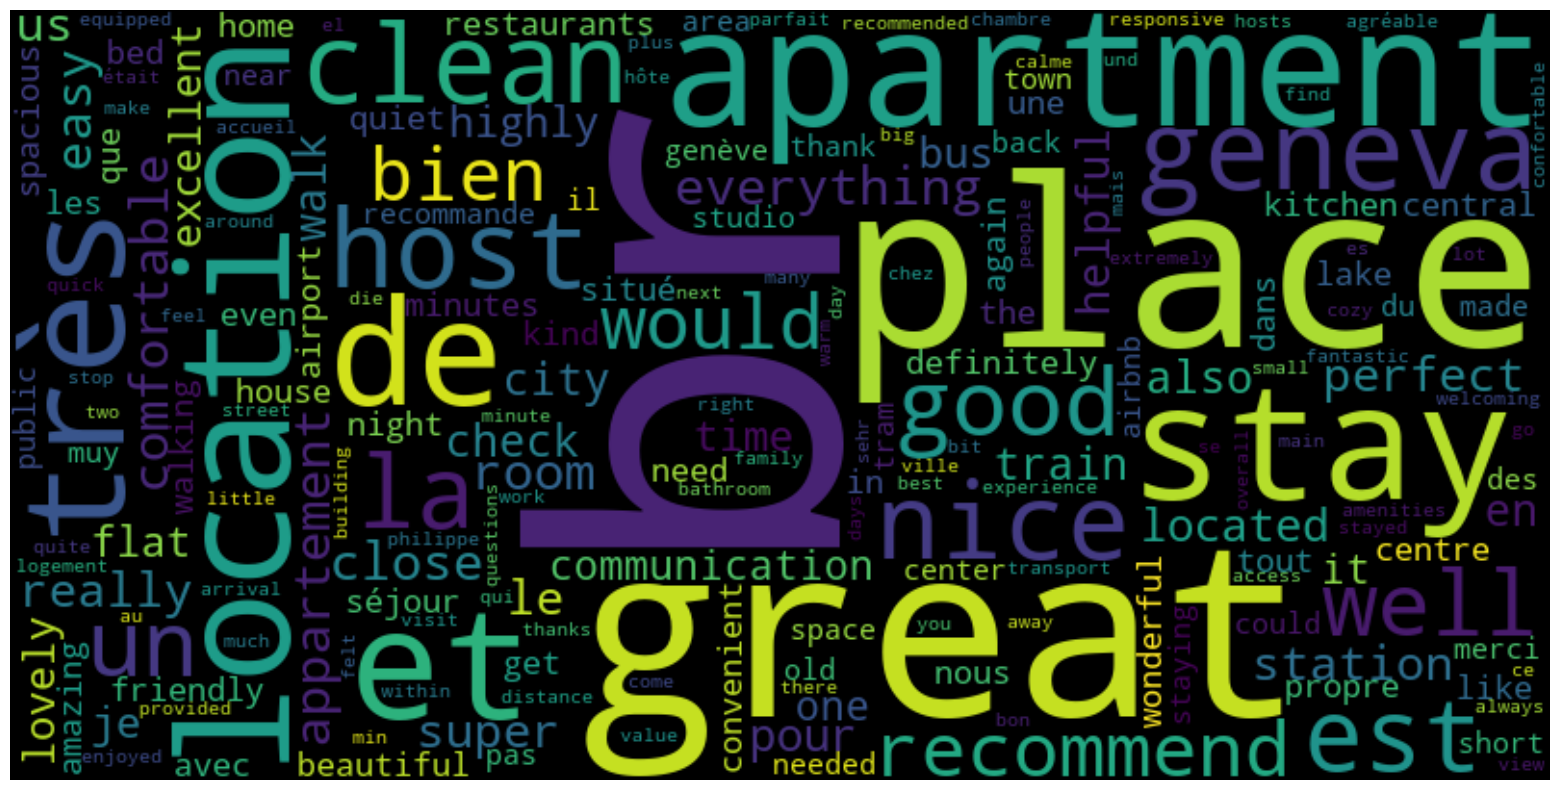

In [190]:
cvec_dict = dict(zip(cvec_df.words, cvec_df.counts))

wordcloud = WordCloud(width=800, height=400)
wordcloud.generate_from_frequencies(frequencies=cvec_dict)
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()